In [203]:
# Importando Bibliotecas
import pandas as pd
from scipy.stats import zscore
from AnalysisUtils import *
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.impute import KNNImputer
from gap_statistic import OptimalK
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn import cluster

In [204]:
def encode_string_columns(df):
  # Select columns of type 'object' or 'category'
  non_numeric_columns = df.select_dtypes(include=['object', 'category'])

  for col in non_numeric_columns.columns:
    # Get the unique values in the column
    unique_values = df[col].dropna().unique()
    
    if col == 'come_entre_refeicoes':
      df['dummy_come_entre_refeicoes'] = df[col].str.lower().map({'nao':0, 'as vezes':1, 'frequentemente':2, 'sempre': 3})
      continue
      
    if col == 'consumo_alcool':
      df['dummy_consumo_alcool'] = df[col].str.lower().map({'nao':0, 'as vezes':1, 'frequentemente':2})
      continue

    if df[col].str.lower().isin(['sim', 'nao']).all():
      df[f"dummy_{col}"] = df[col].str.lower().map({'sim': 1, 'nao': 0})
      continue
      
    if len(unique_values) == 2:
      label_encoder = LabelEncoder()
      df[f"dummy_{col}"] = label_encoder.fit_transform(df[col])
      continue
    else:
      df_dummies = pd.get_dummies(df[col], prefix=f"dummy_{col}")
      df = pd.concat([df, df_dummies], axis=1)
      continue
        
  return df

def fill_missing_data(df, method='simple', n_neighbors=5):
  if method == 'simple':
    for col in df.columns:
      if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].mean())
      else:
        if df[col].notna().any():
          df[col] = df[col].fillna(df[col].mode()[0])

  elif method == 'knn':
    # Separate numeric and non-numeric columns
    df_numeric = df.select_dtypes(include=['float64', 'int64'])
    df_non_numeric = df.select_dtypes(exclude=['float64', 'int64'])

    # Apply get_dummies for non-numeric columns to perform one-hot encoding
    df_non_numeric_dummies = pd.get_dummies(df_non_numeric, drop_first=False)

    # Impute using KNN
    imputer_numeric = KNNImputer(n_neighbors=n_neighbors)
    imputer_non_numeric = KNNImputer(n_neighbors=1)
    
    df_imputed_numeric = pd.DataFrame(
      imputer_numeric.fit_transform(df_numeric),
      columns=df_numeric.columns,
      index=df_numeric.index
    )

    df_imputed_non_numeric = pd.DataFrame(
      imputer_non_numeric.fit_transform(df_non_numeric_dummies),
      columns=df_non_numeric_dummies.columns,
      index=df_non_numeric_dummies.index
    )
    # Reverse the one-hot encoding by getting the most frequent category for each column
    df_non_numeric_imputed = pd.DataFrame(index=df_imputed_non_numeric.index)
    for col in df_non_numeric.columns:
      vals_col = df_non_numeric[col].dropna().unique()
      
      dummies = [col + '_' + str(val) for val in vals_col]
      dummies_values = df_imputed_non_numeric[dummies].idxmax(axis=1).apply(lambda x: x.split('_')[-1])
      df_non_numeric_imputed[col] = dummies_values

    # Combine numeric and non-numeric back to the original DataFrame
    df = pd.concat([df_imputed_numeric, df_non_numeric_imputed], axis=1)

  else:
    raise ValueError("Invalid method. Choose from 'simple' or 'knn'.")

  return df

def detect_outliers(df):
  z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
  outliers = z_scores > 3  # Consider values with Z-score greater than 3 as outliers
  return outliers.sum()

def analyze_numerical_column(row):
  print_simple_metrics(row)
  boxplot_with_quartiles(row, yscale='linear')
  create_filtered_histograms(row, log=False, filters=None, color='blue', bins=100)

def calculate_group_metric(df, category_columns, numerical_columns, metric='median'):
  result_list = []

  for i in range(len(category_columns)):
    for value in df[category_columns[i]].unique():
      group_df = df[df[category_columns[i]] == value]

      if metric == 'median':
        group_metric = group_df[numerical_columns].median()
      else:
        group_metric = group_df[numerical_columns].mean()

      group_metric['category'] = f"{category_columns[i]}: {value}"
      result_list.append(group_metric)

  result_df = pd.DataFrame(result_list)

  return result_df

def plot_sorted_group_metric(result_df, numerical_columns, metric='median'):
  for col in numerical_columns:
    # Sort the result DataFrame by the median of the current column
    sorted_df = result_df.set_index('category').sort_values(by=col).reset_index()

    # Create a new figure for each numerical column
    plt.figure(figsize=(12, 8))

    # Prepare the boxplot data by creating a new DataFrame with the sorted categories
    sorted_categories = sorted_df['category'].values
    boxplot_data = []

    for category in sorted_categories:
      # Create the boxplot data by selecting the group corresponding to each category
      group_category = category.split(":")[0]  # Extract the category name from 'column: value'
      group_value = category.split(":")[1].strip()  # Extract the value
      group_df = df[df[group_category] == group_value]  # Get the subgroup
      boxplot_data.append(group_df[col].values)

    # Create the boxplot, aligned by the sorted categories
    sns.boxplot(data=boxplot_data, order=range(len(sorted_categories)))

    # Set labels and title for the plot
    plt.xticks(range(len(sorted_categories)), sorted_categories, rotation=45, ha='right')
    plt.xlabel('Category')
    plt.ylabel(f'{metric} of {col}')
    plt.title(f'Sorted {metric}s of {col} by Category')
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_all_category_columns(df, category_columns, color='skyblue', top=10):
  num_columns = len(category_columns)
  rows = (num_columns // 3) + (num_columns % 3 > 0)

  fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
  axes = axes.flatten()

  for idx, column in enumerate(category_columns):
    ax = axes[idx]

    # Get the value counts for the encoded column
    result_df = df[column].value_counts().reset_index()
    result_df.columns = [column, 'Count']
    result_df['Percentage'] = (result_df['Count'] / result_df['Count'].sum()) * 100

    # Keep only top N values if specified
    result_df = result_df.head(top)

    # Plot the bar chart
    result_df.plot(kind='bar', x=column, y='Count', color=color, ax=ax, legend=False)

    ax.set_title(f"Value Counts of {column}", fontsize=12, pad=20)
    ax.set_xlabel('Values', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.tick_params(axis='x', rotation=45)

    for i, (count, pct) in enumerate(zip(result_df['Count'], result_df['Percentage'])):
      ax.text(i, count + 0.5, f'{count} / {pct:.1f}%', ha='center', va='bottom')

  # Remove any empty axes
  for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

  plt.subplots_adjust(hspace=0.5, wspace=0.3)
  plt.tight_layout()
  plt.show()

def scale_data(df, columns):
  scaler = StandardScaler()
  df[columns] = scaler.fit_transform(df[columns])
  return df

def scale_and_prepare_data(df, categorical_columns, numerical_columns):
  # One-hot encode categorical columns
  df_dummies = pd.get_dummies(df[categorical_columns], drop_first=True)

  # Initialize StandardScaler
  scaler = StandardScaler()

  # Scale the specified numerical columns
  df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

  # Scale the one-hot encoded categorical columns (df_dummies)
  df_dummies_scaled = scaler.fit_transform(df_dummies)

  # Convert the scaled dummies back to a DataFrame and assign correct column names manually
  df_dummies_scaled = pd.DataFrame(df_dummies_scaled, columns=df_dummies.columns, index=df.index)

  # Concatenate the scaled numerical columns with the scaled one-hot encoded columns
  df = pd.concat([df[numerical_columns], df_dummies_scaled], axis=1)

  return df

def add_health_columns(df):
    # Calcular IMC
    df['IMC'] = df['peso'] / (df['altura'] ** 2)

    # Classificar IMG
    def classify_imc(img):
        if img <= 18.5:
            return 'Baixo'
        elif img <= 24.9:
            return 'Normal'
        elif img <= 29.9:
            return 'Sobrepeso'
        else:
            return 'Obesidade'

    df['Class_IMC'] = df['IMC'].apply(classify_imc)

    return df

def plot_and_return_correlation(df, category_columns_dummies, numeric_columns, method='spearman', plot=True):

  df_numeric = df[numeric_columns + category_columns_dummies]

  correlation_matrix = df_numeric.corr(method=method)

  # Plot the heatmap
  if plot:
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlação ({method.capitalize()})')
    plt.show()

  # Flatten the correlation matrix and sort by absolute value
  corr_pairs = correlation_matrix.unstack()
  sorted_corr = corr_pairs.sort_values(key=lambda x: x.abs(), ascending=False)

  # Exclude self-correlations
  filtered_corr = sorted_corr[sorted_corr.index.get_level_values(0) != sorted_corr.index.get_level_values(1)]

  # Remove duplicates like [A, B] and [B, A]
  unique_pairs = filtered_corr.reset_index()
  unique_pairs['sorted_index'] = unique_pairs.apply(lambda row: tuple(sorted([row['level_0'], row['level_1']])), axis=1)
  unique_pairs = unique_pairs.drop_duplicates(subset='sorted_index').drop(columns='sorted_index')

  # Rename columns for clarity
  unique_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

  return unique_pairs, correlation_matrix

def show_changed_missing_values(df1, df2):

  df1_ordered = df1[df2.columns]
  changed = df1_ordered != df2
  changed_rows_df1 = df1_ordered[changed].dropna(how='all')
  changed_rows_df2 = df2[changed].dropna(how='all')

  merged_values = changed_rows_df1.combine(
    changed_rows_df2,
    lambda x1, x2: pd.Series([f"{v1} | {v2}" if pd.notna(v1) and pd.notna(v2) else None for v1, v2 in zip(x1, x2)])
  )

  return merged_values

def pca_analysis(df, columns, plot=True):
  # Performing PCA
  pca_df = df[columns].copy()
  pca = PCA()
  pca_data = pca.fit_transform(pca_df)
  for i in range(pca_data.shape[1]):
    pca_df[f'pca{i+1}'] = pca_data[:, i]

  # Loading components
  loadings = pd.DataFrame(
    pca.components_,
    columns=pca_df.columns[:pca.components_.shape[-1]],
    index=[f'PCA{i + 1}' for i in range(pca.n_components_)]
  )

  # Explained variance ratio and PCA contributions
  explained_variance_ratio = pca.explained_variance_ratio_
  pca_contributions = (explained_variance_ratio[:5]).round(4)
  
  if plot:
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_df['pca1'], pca_df['pca2'], s=50)
    plt.title("PCA Clustering")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

  sorted_loadings = {}
  for i in range(pca.n_components_):
    pca_component = f'PCA{i + 1}'
    top_contributors = loadings.iloc[i].abs().sort_values(ascending=False).head(5)

    # Create a dictionary for the top contributors and their contributions
    sorted_loadings[pca_component] = {
      feature: top_contributors[feature] for feature in top_contributors.index
    }

  return pca_df, sorted_loadings, pca_contributions

def pca_explained_variance_plot(df, columns):
  pca_df = df[columns].copy()
  pca = PCA()
  pca_data = pca.fit_transform(pca_df)
  explained_variance_ratio = pca.explained_variance_ratio_
  cumulative_explained_variance = explained_variance_ratio.cumsum()

  # Plot the cumulative explained variance vs the number of principal components
  plt.figure(figsize=(8, 6))
  plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
  plt.title("Cumulative Explained Variance vs. Number of Principal Components")
  plt.xlabel("Number of Principal Components")
  plt.ylabel("Cumulative Explained Variance (%)")
  plt.xticks(range(1, len(explained_variance_ratio) + 1))
  plt.yticks([i / 10 for i in range(0, 11)])
  plt.grid(True)
  plt.show()

  # Now, let's calculate and plot the contribution of each original column to the total variance explained
  loadings = pd.DataFrame(
    pca.components_,
    columns=pca_df.columns[:pca.components_.shape[-1]],
    index=[f'PCA{i + 1}' for i in range(pca.n_components_)]
  )
  
  # Calculate the contribution of each original feature across all principal components
  feature_contributions = loadings.abs().sum(axis=0).sort_values(ascending=False)
  
  plt.figure(figsize=(12, 8))  # Set larger figure size
  feature_contributions.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 8))
  plt.title("Feature Contribution to PCA Components", fontsize=16, fontweight='bold')
  plt.xlabel("Original Features", fontsize=12)
  plt.ylabel("Total Contribution to PCA Components", fontsize=12)
  plt.xticks(rotation=45, ha='right', fontsize=10)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.show()

  return cumulative_explained_variance, feature_contributions

def kmeans_elbow(df, max_clusters):
  # Lista para armazenar os valores de inertia
  inertias = []

  # Testar diferentes números de clusters (k)
  k_values = range(1, max_clusters + 1)
  for k in k_values:
      kmeans = KMeans(n_clusters=k, random_state=0)
      kmeans.fit(df)
      inertias.append(kmeans.inertia_)

  # Plotar o gráfico do método do cotovelo
  plt.figure(figsize=(8, 5))
  plt.plot(k_values, inertias, 'o-', color='blue')
  plt.xlabel('Número de clusters (k)')
  plt.ylabel('Inércia')
  plt.title('Método do Cotovelo')
  plt.xticks(k_values)
  plt.grid(True)
  plt.show()

def silhouette_score_clusters_plot(df, max_clusters):
  # Testar diferentes valores de k
  best_clusters_amount = 0
  max_silhouette_score = -1
  silhouette_scores = []
  k_values = range(2, max_clusters + 1)

  for k in k_values:
      kmeans = KMeans(n_clusters=k, random_state=0)
      labels = kmeans.fit_predict(df)
      score = silhouette_score(df, labels)
      silhouette_scores.append(score)
      
      if score > max_silhouette_score:
        best_clusters_amount = k
        max_silhouette_score = score

  # Plotar o Silhouette Score
  plt.figure(figsize=(8, 5))
  plt.plot(k_values, silhouette_scores, 'o-', color='green')
  plt.xticks(k_values)
  plt.xlabel('Número de clusters (k)')
  plt.ylabel('Coeficiente de Silhueta')
  plt.title('Coeficiente de Silhueta para diferentes k')
  plt.grid(True)
  plt.show()

  return best_clusters_amount, max_silhouette_score

def davies_bouldin_index(df, max_clusters):
  best_clusters_amount = 0
  min_davies_bouldin_index = 99999999
  db_scores = []
  k_values = range(2, max_clusters + 1)

  for k in k_values:
      kmeans = KMeans(n_clusters=k, random_state=0)
      labels = kmeans.fit_predict(df)
      score = davies_bouldin_score(df, labels)
      db_scores.append(score)

      if score < min_davies_bouldin_index:
        min_davies_bouldin_index = score
        best_clusters_amount = k

  # Plotar Davies-Bouldin Index
  plt.figure(figsize=(8, 5))
  plt.plot(k_values, db_scores, 'o-', color='purple')
  plt.xlabel('Número de clusters (k)')
  plt.ylabel('Davies-Bouldin Index')
  plt.title('Davies-Bouldin Index para diferentes k')
  plt.grid(True)
  plt.show()

  return best_clusters_amount, min_davies_bouldin_index

def optimal_k_clusters(df, max_clusters):
  optimalK = OptimalK(parallel_backend='joblib')
  return optimalK(df, cluster_array=np.arange(1, max_clusters + 1))

def kmeans_clusters_amount_analysis(df, max_clusters):
  kmeans_elbow(df, max_clusters)

  best_clusters_amount_silhouette, max_silhouette_score = silhouette_score_clusters_plot(df, max_clusters)
  best_clusters_amount_db, min_davies_bouldin_index = davies_bouldin_index(df, max_clusters)
  n_clusters = optimal_k_clusters(df, max_clusters)

  print(f'Melhor quantidade de clusters: {best_clusters_amount_silhouette} | Silhueta: {max_silhouette_score}')
  print(f'Melhor quantidade de clusters: {best_clusters_amount_db} | Davies Bouldin Index: {min_davies_bouldin_index}')
  print(f'Melhor quantidade de clusters pelo OptimalK: {n_clusters}')

def plot_clusters_pca(df, labels, cluster_centers=None):
  pca = PCA(n_components=2)
  reduced_data = pca.fit_transform(df)

  plt.figure(figsize=(8, 6))

  unique_labels = np.unique(labels)
  for label in unique_labels:
    if label == -1:
        color = 'black'
        label_name = 'Noise'
    else:
        color = None
        label_name = f'Cluster {label}'
    
    cluster_data = reduced_data[labels == label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=label_name, c=color)
  
  if cluster_centers is not None:
    centroids = pca.transform(cluster_centers)
    plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='black', marker='x', label='Centroids')
  
  plt.title("Clusters visualizados com PCA")
  plt.xlabel("PCA Componente 1")
  plt.ylabel("PCA Componente 2")
  plt.legend()
  plt.show()


def kmeans_analysis(df, n_clusters, plot=True):
  kmeans = cluster.KMeans(n_clusters=n_clusters)
  y_kmeans = kmeans.fit_predict(df)

  if not plot:
    return y_kmeans
  
  plot_clusters_pca(df, kmeans.labels_, kmeans.cluster_centers_)

def dbscan_analysis(df, eps, min_samples, plot=True):
  dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples)
  y_dbscan = dbscan.fit_predict(df)

  if not plot:
    return y_dbscan
  
  labels = dbscan.labels_
  plot_clusters_pca(df, labels)  


In [205]:
numerical_columns = ['idade', 'idade_int', 'altura', 'peso', 'consome_vegetais', 'consome_vegetais_int', 'n_refeicoes_int', 'consumo_diario_agua', 'consumo_diario_agua_int', 'frequencia_atividade_fisica', 'frequencia_atividade_fisica_int', 'tempo_usando_eletronicos', 'tempo_usando_eletronicos_int', 'IMC']

category_columns = ['sexo', 'historico_obesidade_familia', 'consome_comida_calorica', 'come_entre_refeicoes', 'fuma', 'consumo_alcool', 'tipo_transporte', 'Class_IMC', 'tipo_transporte_adaptado']

category_columns_dummies = [
  'dummy_sexo',
  'dummy_historico_obesidade_familia',
  'dummy_consome_comida_calorica',
  'dummy_come_entre_refeicoes',
  'dummy_consumo_alcool',
  'dummy_fuma',
  'dummy_tipo_transporte_adaptado_ativo',
  'dummy_tipo_transporte_adaptado_individual',
  'dummy_tipo_transporte_adaptado_transporte publico'
]

In [206]:
# df.columns

# Comparação de estratégias de inputting

In [207]:
df_test = pd.read_csv('data/trabalho2_dados_4.csv')
missing_rows_idx = df_test[df_test.isna().any(axis=1)].index.tolist()

df_test_knn = fill_missing_data(df_test, method='knn')
df_test_simple = fill_missing_data(df_test, method='simple')

show_changed_missing_values(df_test_knn, df_test_simple)

sexo                            idade altura  peso  \
0     None                             None   None  None   
3     None                             None   None  None   
9     None  20.5949296 | 24.304109994366197   None  None   
14    None                             None   None  None   
16    None                             None   None  None   
...    ...                              ...    ...   ...   
1087  None                             None   None  None   
1089  None                             None   None  None   
1091  None                             None   None  None   
1094  None                             None   None  None   
1098  None                             None   None  None   

     historico_obesidade_familia consome_comida_calorica  \
0                           None                    None   
3                           None                    None   
9                           None                    None   
14                          None                    None   
16                          None                    None   
...                          ...                     ...   
1087                        None                    None   
1089                        None                    None   
1091                        None                    None   
1094                        None                    None   
1098                        None                    None   

                    consome_vegetais              n_refeicoes  \
0     2.2021876 | 2.4096084051233397                     None   
3                               None  3.0 | 2.676319636022514   
9                               None                     None   
14                              None                     None   
16                              None                     None   
...                              ...                      ...   
1087  2.5094212 | 2.4096084051233397                     None   
1089                            None  3.0 | 2.676319636022514   
1091        3.0 | 2.4096084051233397                     None   
1094                            None                     None   
1098                            None                     None   

     come_entre_refeicoes  fuma                      consumo_diario_agua  \
0                    None  None                                     None   
3                    None  None           2.1873876 | 2.0033957880794704   
9                    None  None           2.3654972 | 2.0033957880794704   
14                   None  None                 1.4 | 2.0033957880794704   
16                   None  None           1.9912654 | 2.0033957880794704   
...                   ...   ...                                      ...   
1087                 None  None                                     None   
1089                 None  None                                     None   
1091                 None  None                                     None   
1094                 None  None  1.4948565999999999 | 2.0033957880794704   
1098                 None  None                                     None   

        frequencia_atividade_fisica                 tempo_usando_eletronicos  \
0     0.646594 | 0.9830633916745505                                     None   
3                              None                                     None   
9                              None                                     None   
14                             None                                     None   
16                             None                                     None   
...                             ...                                      ...   
1087                           None                                     None   
1089                           None                                     None   
1091       0.0 | 0.9830633916745505                                     None   
1094                           None                                   

## buscando duplicada nova gerada com inputting (gerou para ambos)
ele tinha transporte publico como NaN, mas ao substiruí-lo virou uma duplicada perfeita.

In [208]:
# analisando duplicata nova gerada pelo fill_missing_data
df_test = pd.read_csv('data/trabalho2_dados_4.csv')

print('Antes do Input')
new_duplicate = df_test.loc[602].copy()
display(df_test[df_test.eq(df_test.loc[1]).all(axis=1)])

df_test = fill_missing_data(df_test) 

print('Depois do Input')
display(df_test.loc[602])
display(df_test[df_test.eq(df_test.loc[1]).all(axis=1)])
new_duplicate

Antes do Input


sexo  idade  altura  peso historico_obesidade_familia  \
1      M   21.0    1.62  70.0                         nao   
20     M   21.0    1.62  70.0                         nao   
37     M   21.0    1.62  70.0                         nao   
369    M   21.0    1.62  70.0                         nao   
471    M   21.0    1.62  70.0                         nao   
501    M   21.0    1.62  70.0                         nao   
759    M   21.0    1.62  70.0                         nao   

    consome_comida_calorica  consome_vegetais  n_refeicoes  \
1                       sim               2.0          1.0   
20                      sim               2.0          1.0   
37                      sim               2.0          1.0   
369                     sim               2.0          1.0   
471                     sim               2.0          1.0   
501                     sim               2.0          1.0   
759                     sim               2.0          1.0   

    come_entre_refeicoes fuma  consumo_diario_agua  \
1                    nao  nao                  3.0   
20                   nao  nao                  3.0   
37                   nao  nao                  3.0   
369                  nao  nao                  3.0   
471                  nao  nao                  3.0   
501                  nao  nao                  3.0   
759                  nao  nao                  3.0   

     frequencia_atividade_fisica  tempo_usando_eletronicos consumo_alcool  \
1                            1.0                       0.0       as vezes   
20                           1.0                       0.0       as vezes   
37                           1.0                       0.0       as vezes   
369                          1.0                       0.0       as vezes   
471                          1.0                       0.0       as vezes   
501                          1.0                       0.0       as vezes   
759                          1.0                       0.0       as vezes   

        tipo_transporte  
1    transporte publico  
20   transporte publico  
37   transporte publico  
369  transporte publico  
471  transporte publico  
501  transporte publico  
759  transporte publico

Depois do Input


sexo                                            M
idade                                        21.0
altura                                       1.62
peso                                         70.0
historico_obesidade_familia                   nao
consome_comida_calorica                       sim
consome_vegetais                              2.0
n_refeicoes                                   1.0
come_entre_refeicoes                          nao
fuma                                          nao
consumo_diario_agua                           3.0
frequencia_atividade_fisica                   1.0
tempo_usando_eletronicos                      0.0
consumo_alcool                           as vezes
tipo_transporte                transporte publico
Name: 602, dtype: object

sexo  idade  altura  peso historico_obesidade_familia  \
1      M   21.0    1.62  70.0                         nao   
20     M   21.0    1.62  70.0                         nao   
37     M   21.0    1.62  70.0                         nao   
369    M   21.0    1.62  70.0                         nao   
471    M   21.0    1.62  70.0                         nao   
501    M   21.0    1.62  70.0                         nao   
602    M   21.0    1.62  70.0                         nao   
759    M   21.0    1.62  70.0                         nao   

    consome_comida_calorica  consome_vegetais  n_refeicoes  \
1                       sim               2.0          1.0   
20                      sim               2.0          1.0   
37                      sim               2.0          1.0   
369                     sim               2.0          1.0   
471                     sim               2.0          1.0   
501                     sim               2.0          1.0   
602                     sim               2.0          1.0   
759                     sim               2.0          1.0   

    come_entre_refeicoes fuma  consumo_diario_agua  \
1                    nao  nao                  3.0   
20                   nao  nao                  3.0   
37                   nao  nao                  3.0   
369                  nao  nao                  3.0   
471                  nao  nao                  3.0   
501                  nao  nao                  3.0   
602                  nao  nao                  3.0   
759                  nao  nao                  3.0   

     frequencia_atividade_fisica  tempo_usando_eletronicos consumo_alcool  \
1                            1.0                       0.0       as vezes   
20                           1.0                       0.0       as vezes   
37                           1.0                       0.0       as vezes   
369                          1.0                       0.0       as vezes   
471                          1.0                       0.0       as vezes   
501                          1.0                       0.0       as vezes   
602                          1.0                       0.0       as vezes   
759                          1.0                       0.0       as vezes   

        tipo_transporte  
1    transporte publico  
20   transporte publico  
37   transporte publico  
369  transporte publico  
471  transporte publico  
501  transporte publico  
602  transporte publico  
759  transporte publico

sexo                                  M
idade                              21.0
altura                             1.62
peso                               70.0
historico_obesidade_familia         nao
consome_comida_calorica             sim
consome_vegetais                    2.0
n_refeicoes                         1.0
come_entre_refeicoes                nao
fuma                                nao
consumo_diario_agua                 3.0
frequencia_atividade_fisica         1.0
tempo_usando_eletronicos            0.0
consumo_alcool                 as vezes
tipo_transporte                     NaN
Name: 602, dtype: object

## Pre processando Dados

In [209]:
# Importando dados
df = pd.read_csv('data/trabalho2_dados_4.csv')
df = fill_missing_data(df, method='knn') # substituindo valores faltantes numéricos pela media e categóricos pela moda


df['idade_int'] = np.floor(df['idade'])
df['n_refeicoes_int'] = df['n_refeicoes'].round()
df['consome_vegetais_int'] = df['consome_vegetais'].round()
df['consumo_diario_agua_int'] = df['consumo_diario_agua'].round()
df['frequencia_atividade_fisica_int'] = df['frequencia_atividade_fisica'].round()
df['tempo_usando_eletronicos_int'] = df['tempo_usando_eletronicos'].round()

df['tipo_transporte_adaptado'] = df['tipo_transporte'].apply(
  lambda x: 'ativo' if x in ['bicicleta', 'andando'] else 'individual' if x in ['carro', 'moto'] else x)

df = add_health_columns(df)
df = encode_string_columns(df) # encodando colunas de string
df = df.drop_duplicates(df, keep='first') # remoção de ~250 entradas duplicadas (substituição de valores faltantes e transformação direta em int nao criaram novas duplicados apenas 1 para o caso de substituição
df.columns

Index(['idade', 'altura', 'peso', 'consome_vegetais', 'n_refeicoes',
       'consumo_diario_agua', 'frequencia_atividade_fisica',
       'tempo_usando_eletronicos', 'sexo', 'historico_obesidade_familia',
       'consome_comida_calorica', 'come_entre_refeicoes', 'fuma',
       'consumo_alcool', 'tipo_transporte', 'idade_int', 'n_refeicoes_int',
       'consome_vegetais_int', 'consumo_diario_agua_int',
       'frequencia_atividade_fisica_int', 'tempo_usando_eletronicos_int',
       'tipo_transporte_adaptado', 'IMC', 'Class_IMC', 'dummy_sexo',
       'dummy_historico_obesidade_familia', 'dummy_consome_comida_calorica',
       'dummy_come_entre_refeicoes', 'dummy_fuma', 'dummy_consumo_alcool',
       'dummy_tipo_transporte_andando', 'dummy_tipo_transporte_bicicleta',
       'dummy_tipo_transporte_carro', 'dummy_tipo_transporte_moto',
       'dummy_tipo_transporte_transporte publico',
       'dummy_tipo_transporte_adaptado_ativo',
       'dummy_tipo_transporte_adaptado_individual',
       '

## Detecção de outliers

In [210]:
detect_outliers(df) 
# Não foram detectados outliers relevantes nas métricas numéricas
# a unica metrica com outliers usando z_score foi a de idade, mas essa distribuição não é normal, e foram apenas 7 encontrados
# nas métricas categóricas, isso removeria certas do categorias do dataset, portanto, não é necessário remover outliers neste dataset

np.int64(51)

## Análises simples

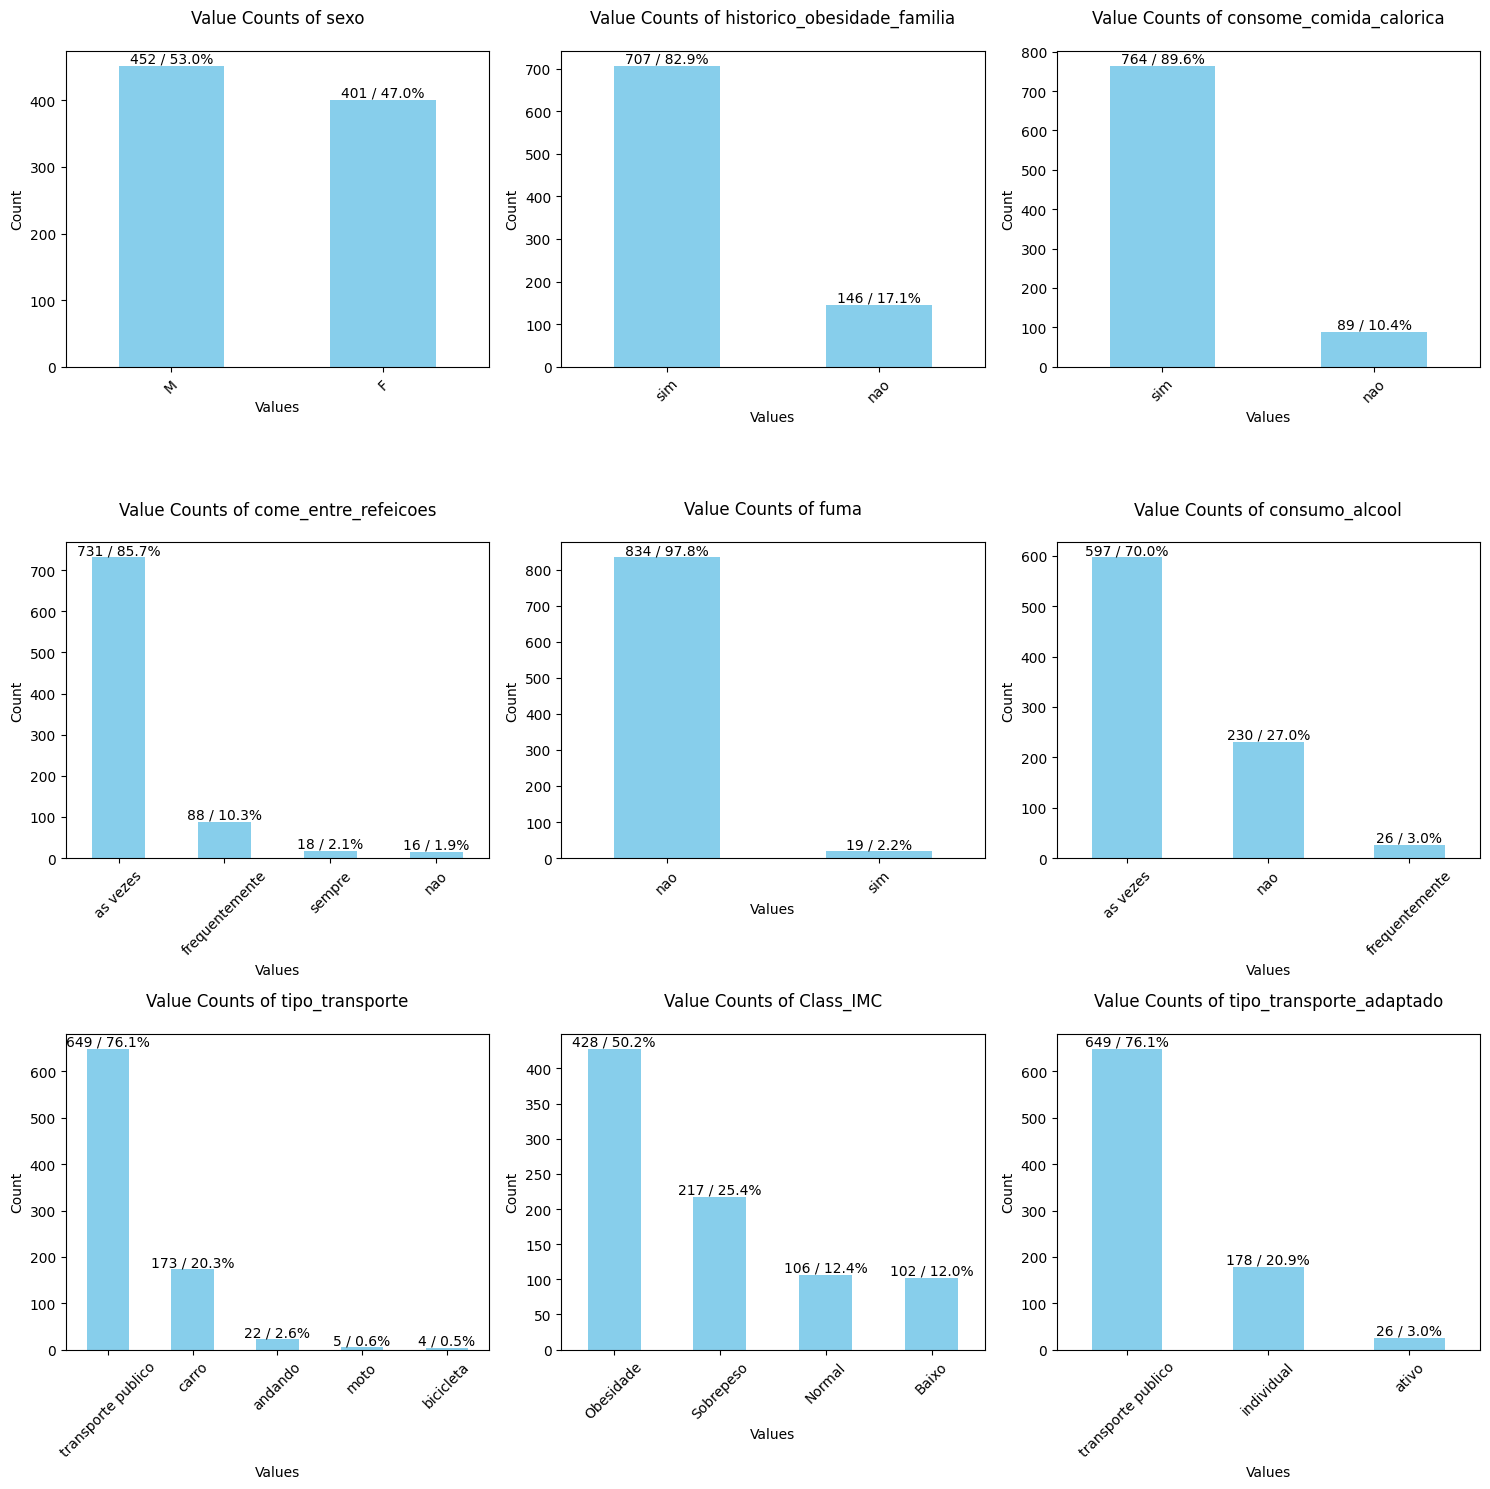

In [211]:
plot_all_category_columns(df, category_columns, color='skyblue', top=10)


--------------------------------------

métricas gerais para idade
média: 24.34259150926143
mediana: 22.874658
desvio padrão: 6.172330468342942
kurtosis: 2.1838590687716017
skewness: 1.4023087930352194

--------------------------------------



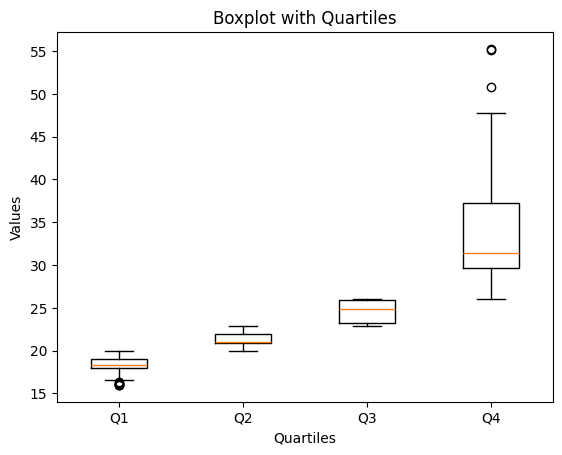


--------------------------------------

Histogramas para a coluna idade com log: False e bins: 100
idade <= 55.24625


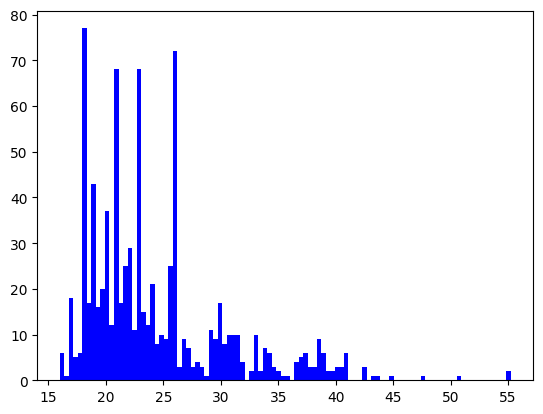


--------------------------------------

idade <= 26.0


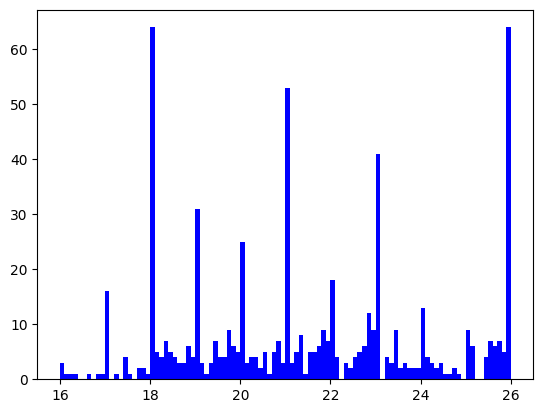


--------------------------------------

idade <= 22.874658


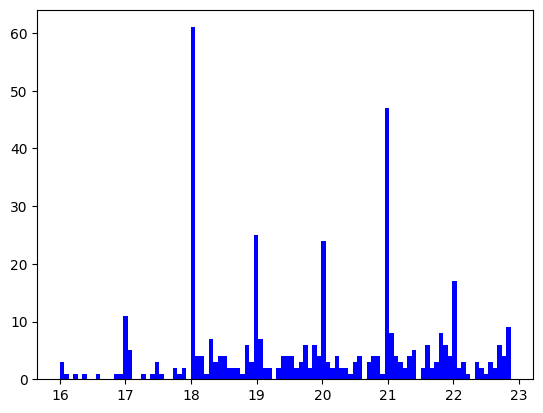


--------------------------------------

idade <= 19.993154


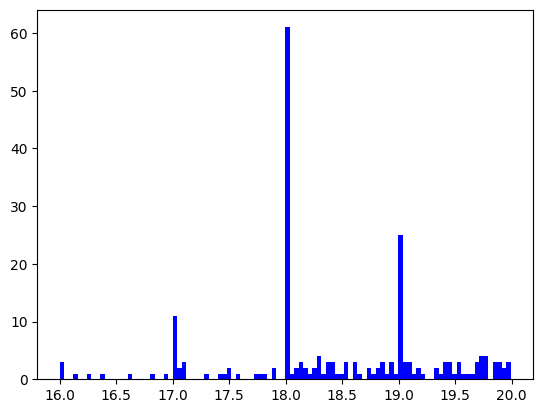


--------------------------------------


--------------------------------------

métricas gerais para idade_int
média: 23.998827667057444
mediana: 22.0
desvio padrão: 6.1201773988974715
kurtosis: 2.2767147898471354
skewness: 1.4265322760405181

--------------------------------------



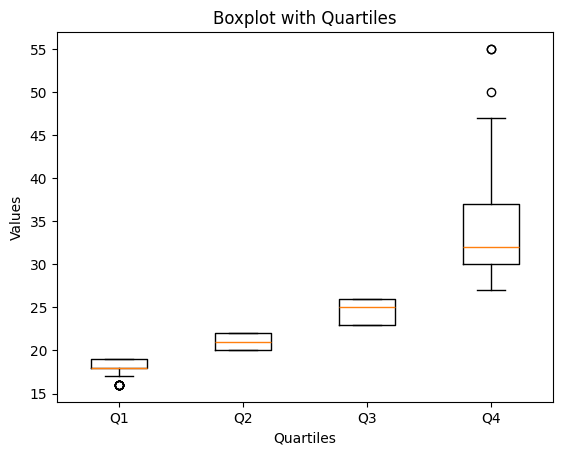


--------------------------------------

Histogramas para a coluna idade_int com log: False e bins: 100
idade_int <= 55.0


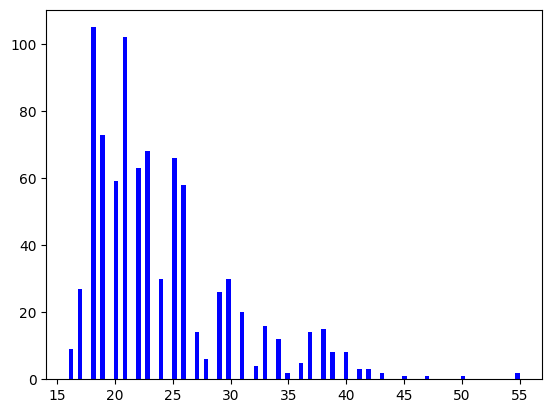


--------------------------------------

idade_int <= 26.0


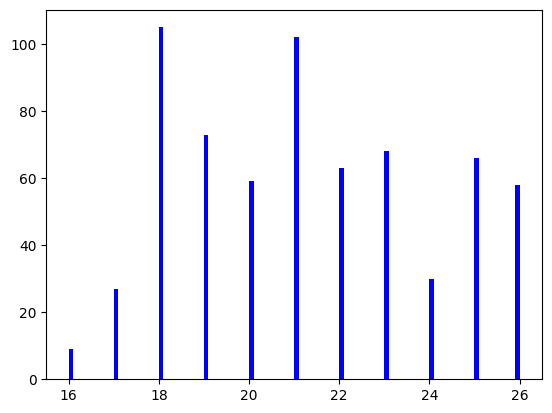


--------------------------------------

idade_int <= 22.0


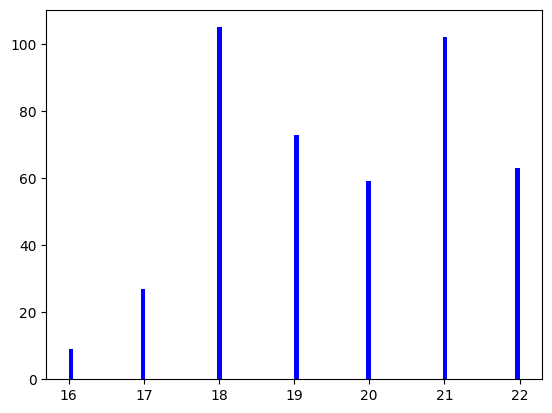


--------------------------------------

idade_int <= 19.0


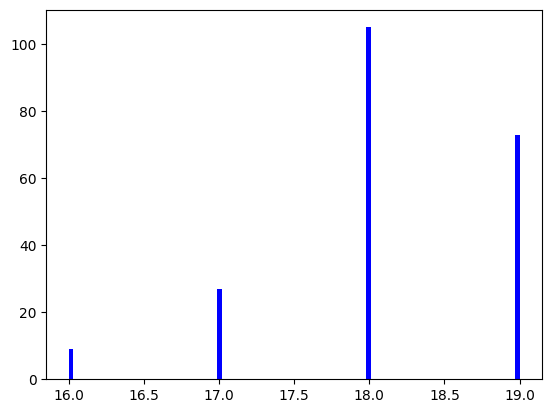


--------------------------------------


--------------------------------------

métricas gerais para altura
média: 1.7044507838218055
mediana: 1.706343
desvio padrão: 0.09443245299874091
kurtosis: -0.4793051343913981
skewness: -0.07070220153834127

--------------------------------------



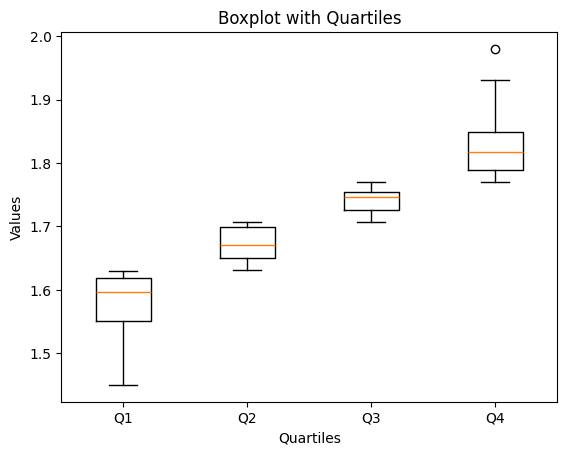


--------------------------------------

Histogramas para a coluna altura com log: False e bins: 100
altura <= 1.98


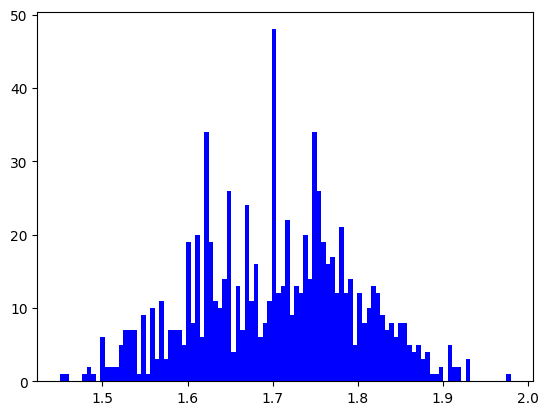


--------------------------------------

altura <= 1.77


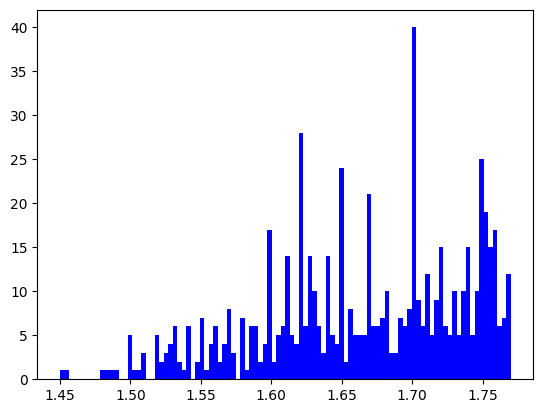


--------------------------------------

altura <= 1.706343


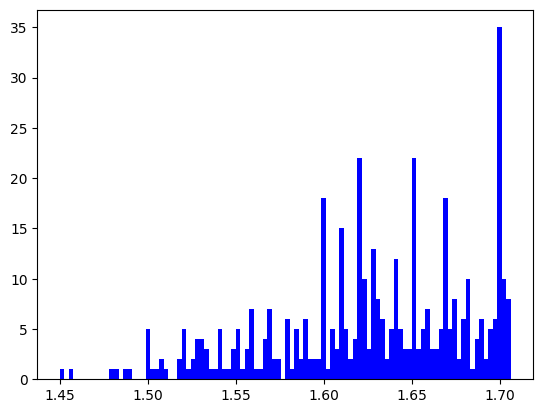


--------------------------------------

altura <= 1.63


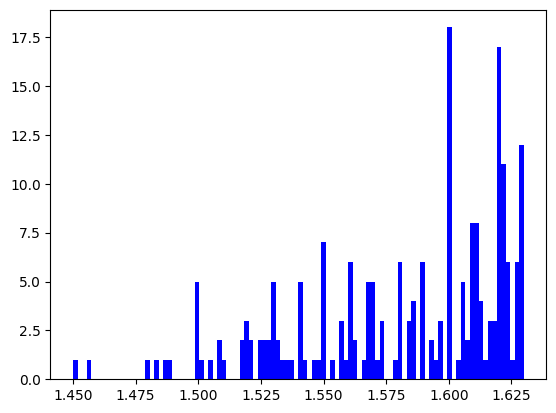


--------------------------------------


--------------------------------------

métricas gerais para peso
média: 88.44027740117235
mediana: 85.0
desvio padrão: 26.191092238322145
kurtosis: -0.840154980030789
skewness: 0.11605432195844477

--------------------------------------



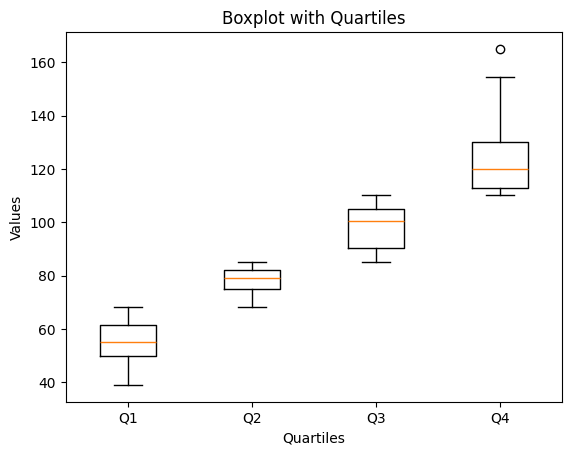


--------------------------------------

Histogramas para a coluna peso com log: False e bins: 100
peso <= 165.057269


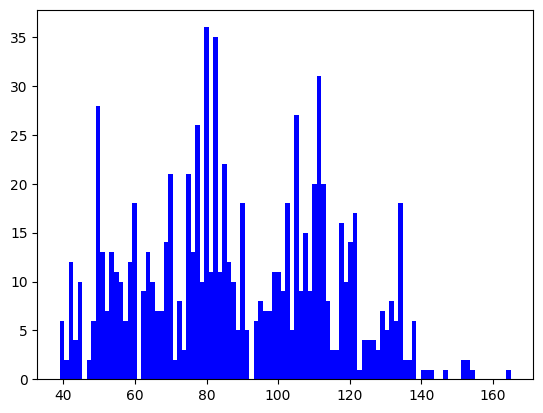


--------------------------------------

peso <= 110.074019


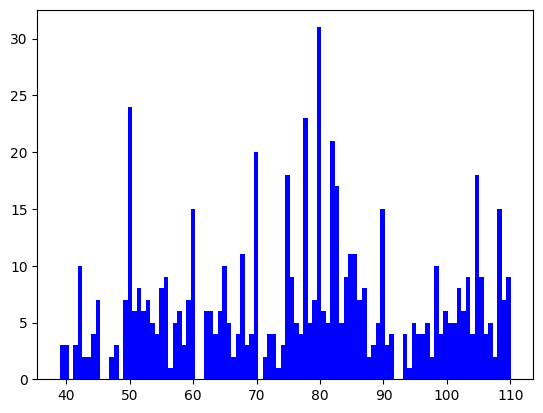


--------------------------------------

peso <= 85.0


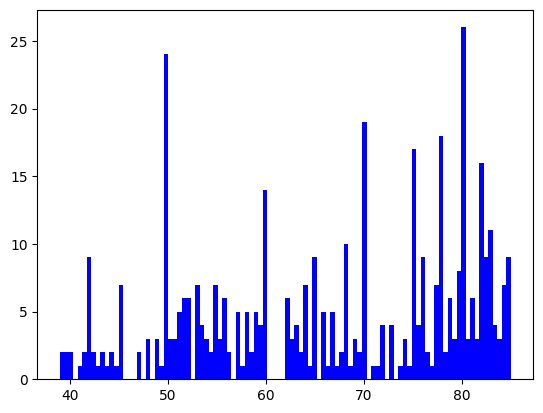


--------------------------------------

peso <= 68.06609


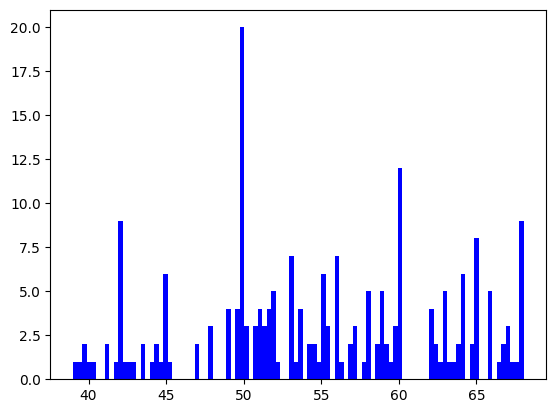


--------------------------------------


--------------------------------------

métricas gerais para consome_vegetais
média: 2.4182583570926144
mediana: 2.357496
desvio padrão: 0.5259236848706454
kurtosis: -0.6628659625488975
skewness: -0.3879658492864853

--------------------------------------



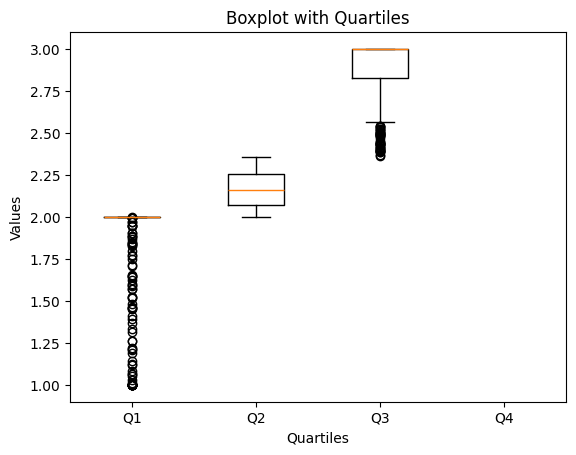


--------------------------------------

Histogramas para a coluna consome_vegetais com log: False e bins: 100
consome_vegetais <= 3.0


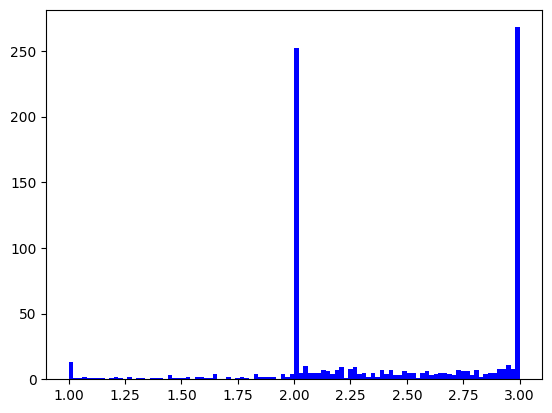


--------------------------------------

consome_vegetais <= 3.0


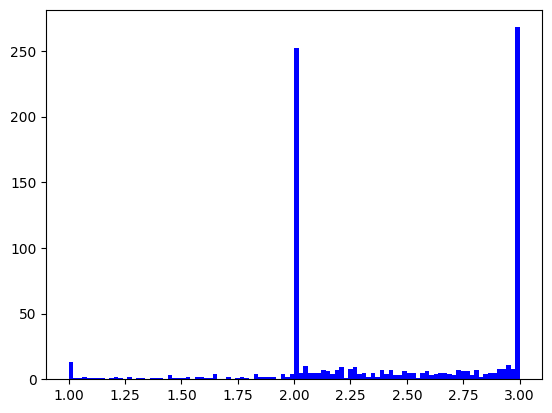


--------------------------------------

consome_vegetais <= 2.357496


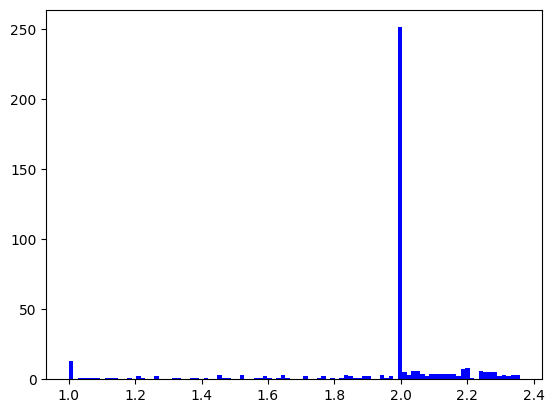


--------------------------------------

consome_vegetais <= 2.0


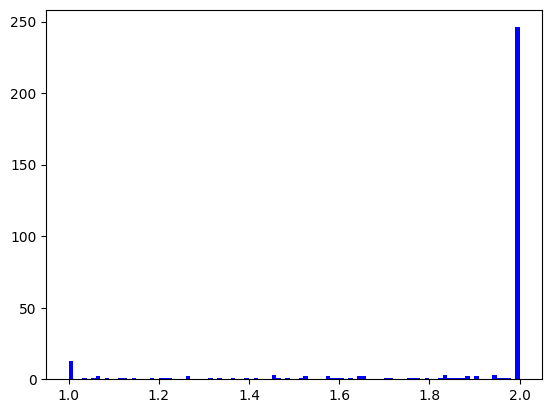


--------------------------------------


--------------------------------------

métricas gerais para consome_vegetais_int
média: 2.41852286049238
mediana: 2.0
desvio padrão: 0.5748926607345548
kurtosis: -0.7645035122584076
skewness: -0.3652000430060411

--------------------------------------



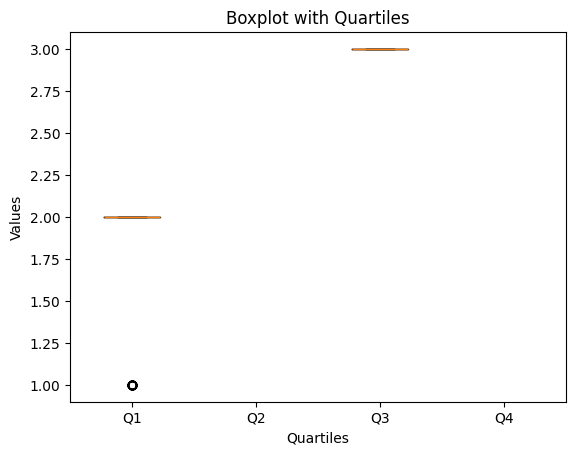


--------------------------------------

Histogramas para a coluna consome_vegetais_int com log: False e bins: 100
consome_vegetais_int <= 3.0


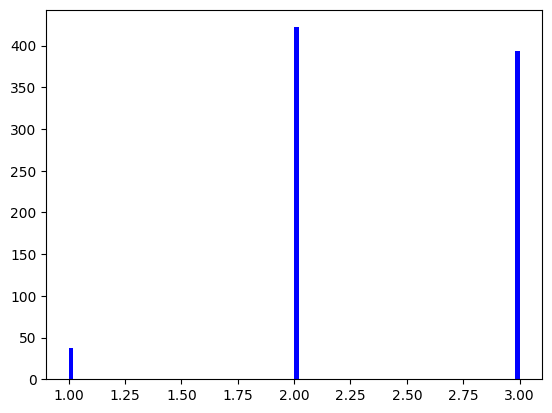


--------------------------------------

consome_vegetais_int <= 3.0


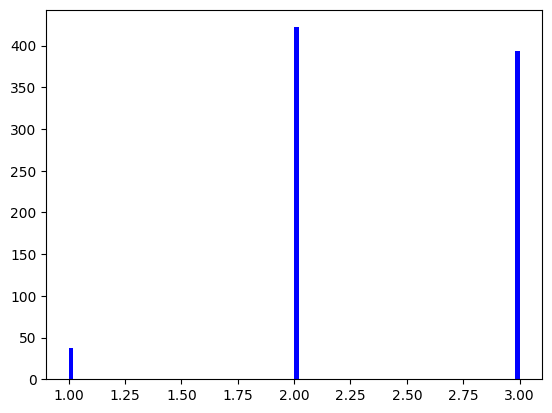


--------------------------------------

consome_vegetais_int <= 2.0


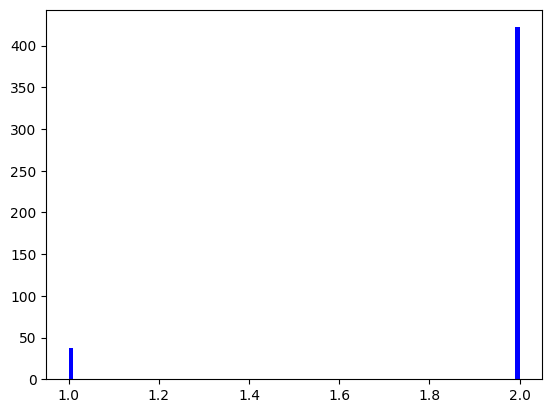


--------------------------------------

consome_vegetais_int <= 2.0


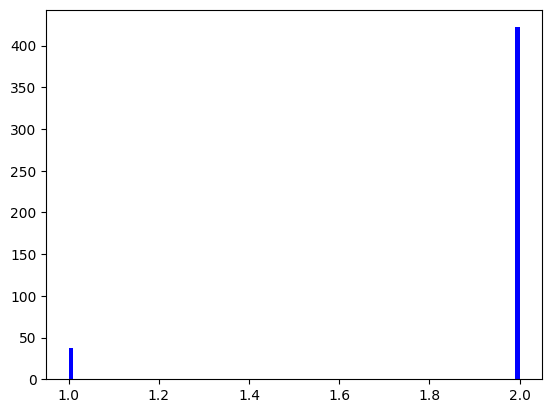


--------------------------------------


--------------------------------------

métricas gerais para n_refeicoes_int
média: 2.694021101992966
mediana: 3.0
desvio padrão: 0.7850865713007785
kurtosis: 0.5934876655369523
skewness: -1.1516395932324597

--------------------------------------



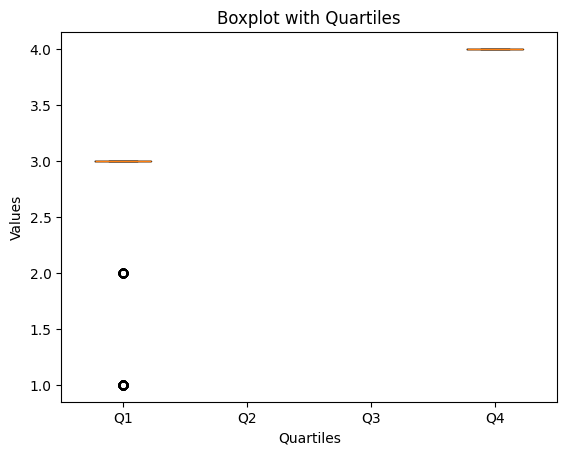


--------------------------------------

Histogramas para a coluna n_refeicoes_int com log: False e bins: 100
n_refeicoes_int <= 4.0


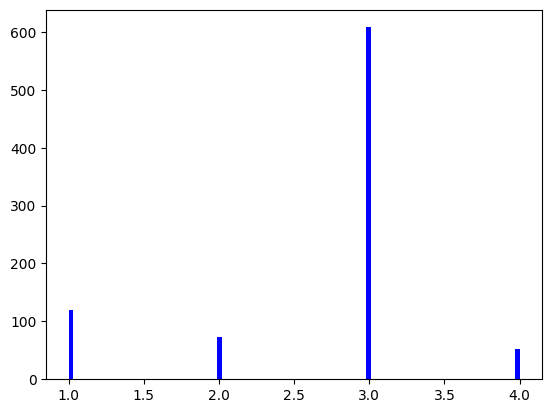


--------------------------------------

n_refeicoes_int <= 3.0


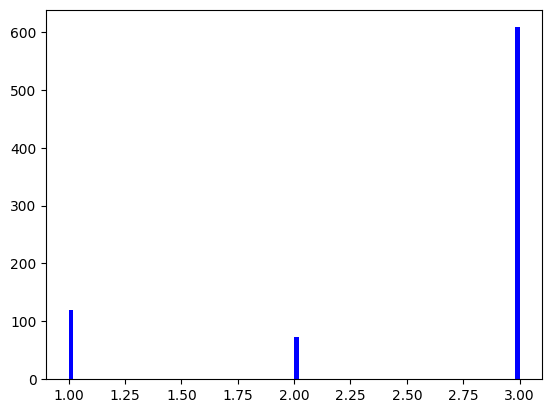


--------------------------------------

n_refeicoes_int <= 3.0


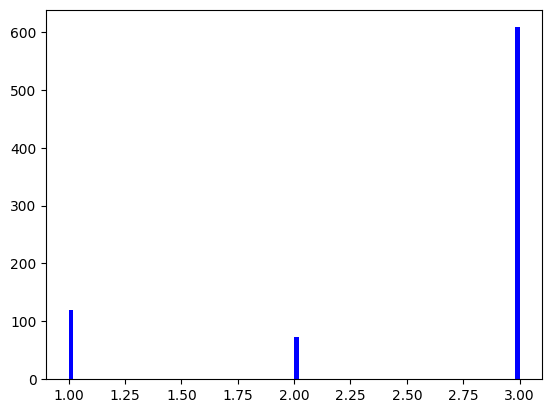


--------------------------------------

n_refeicoes_int <= 3.0


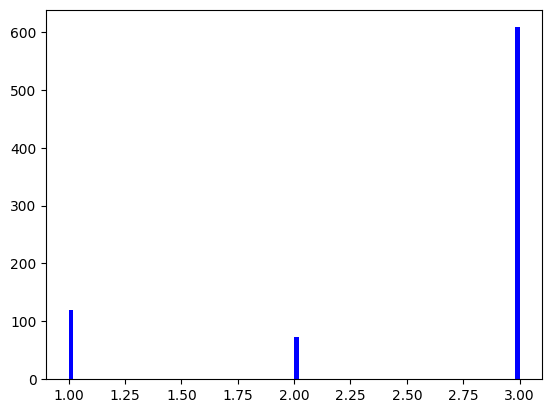


--------------------------------------


--------------------------------------

métricas gerais para consumo_diario_agua
média: 1.999280094490035
mediana: 2.0
desvio padrão: 0.6171528919302597
kurtosis: -0.9369854961874204
skewness: -0.10570333058691887

--------------------------------------



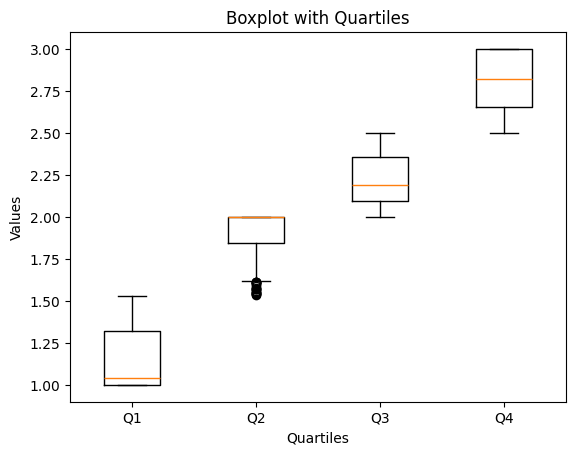


--------------------------------------

Histogramas para a coluna consumo_diario_agua com log: False e bins: 100
consumo_diario_agua <= 3.0


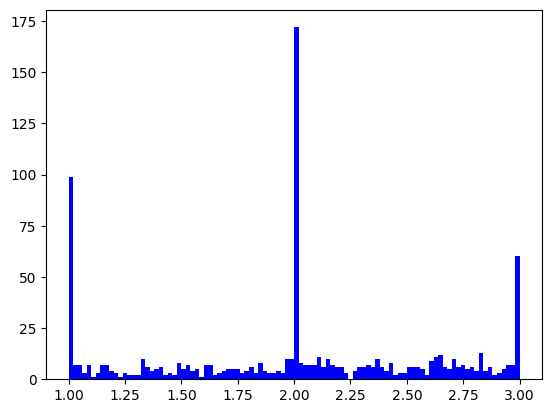


--------------------------------------

consumo_diario_agua <= 2.497065


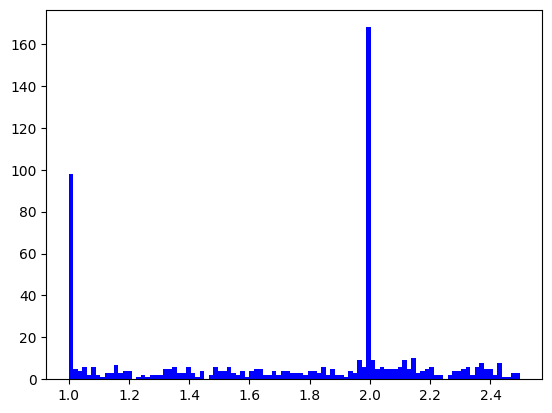


--------------------------------------

consumo_diario_agua <= 2.0


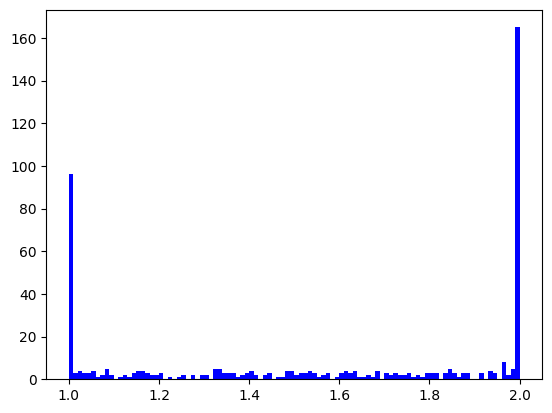


--------------------------------------

consumo_diario_agua <= 1.530992


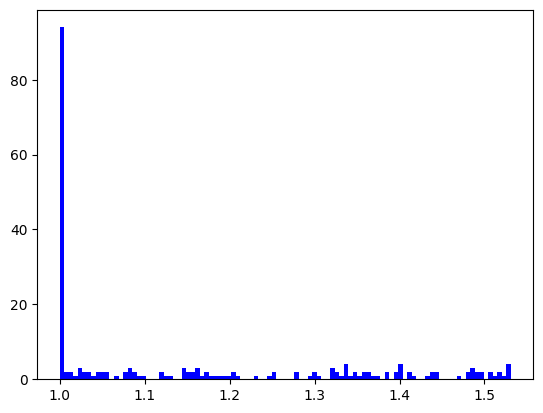


--------------------------------------


--------------------------------------

métricas gerais para consumo_diario_agua_int
média: 2.0105509964830013
mediana: 2.0
desvio padrão: 0.6995178093015997
kurtosis: -0.9540018272670867
skewness: -0.014400847779814048

--------------------------------------



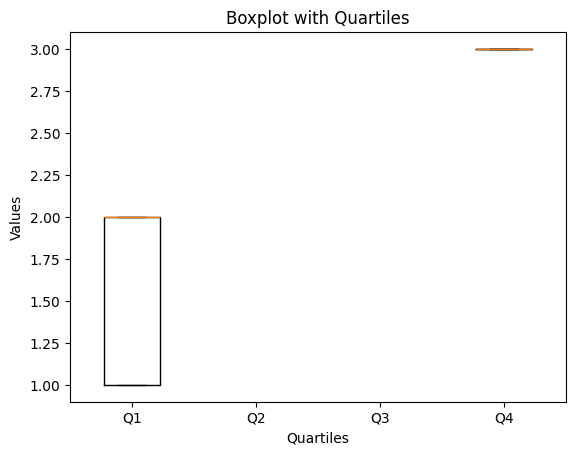


--------------------------------------

Histogramas para a coluna consumo_diario_agua_int com log: False e bins: 100
consumo_diario_agua_int <= 3.0


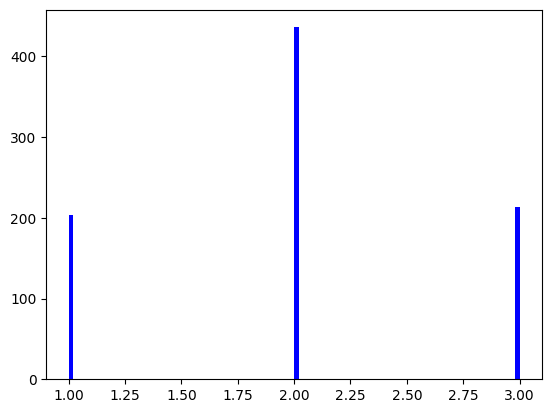


--------------------------------------

consumo_diario_agua_int <= 2.0


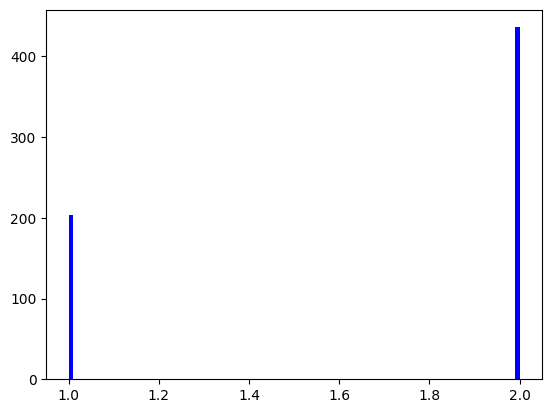


--------------------------------------

consumo_diario_agua_int <= 2.0


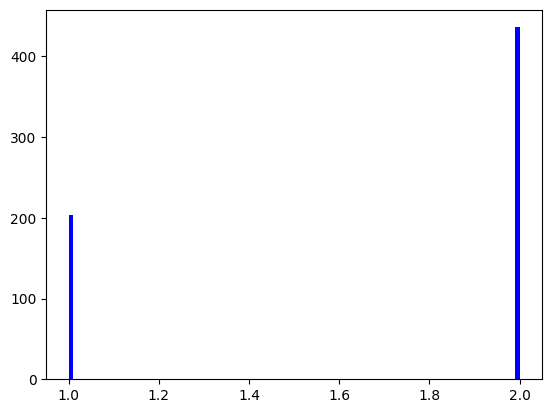


--------------------------------------

consumo_diario_agua_int <= 2.0


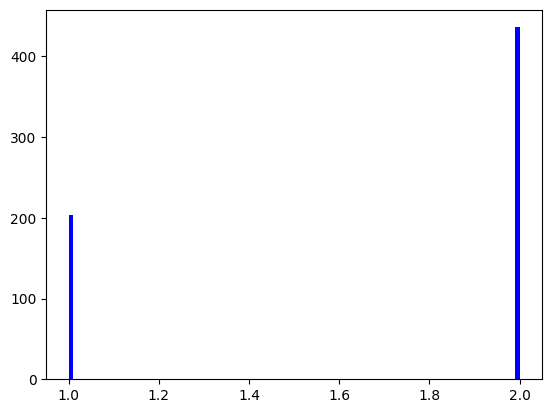


--------------------------------------


--------------------------------------

métricas gerais para frequencia_atividade_fisica
média: 0.9831152304806564
mediana: 1.0
desvio padrão: 0.8478697420724876
kurtosis: -0.5086003107016817
skewness: 0.5635205129364471

--------------------------------------



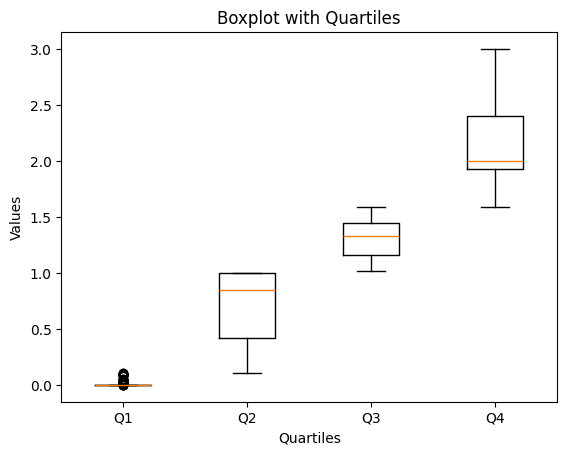


--------------------------------------

Histogramas para a coluna frequencia_atividade_fisica com log: False e bins: 100
frequencia_atividade_fisica <= 3.0


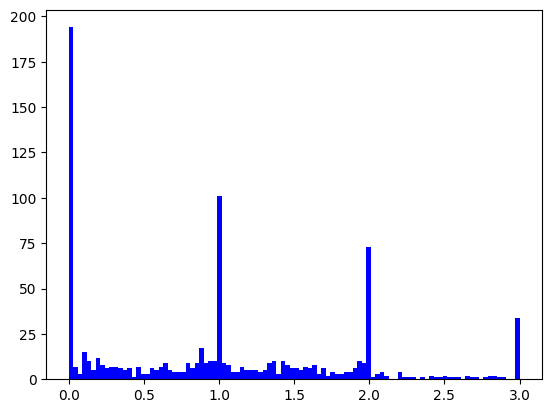


--------------------------------------

frequencia_atividade_fisica <= 1.587406


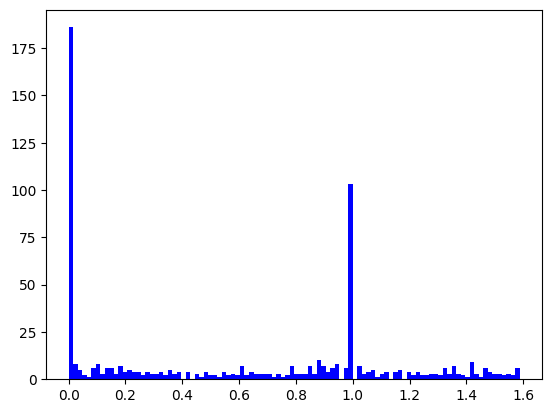


--------------------------------------

frequencia_atividade_fisica <= 1.0


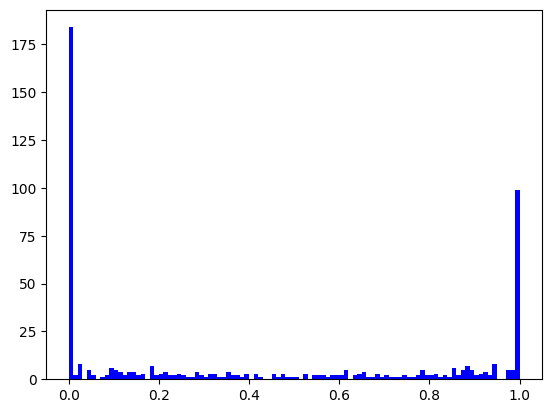


--------------------------------------

frequencia_atividade_fisica <= 0.10928040000000001


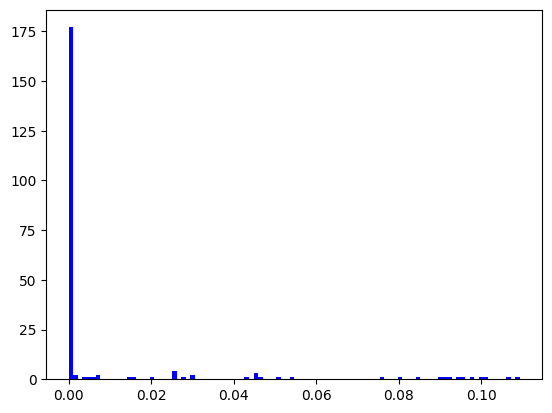


--------------------------------------


--------------------------------------

métricas gerais para frequencia_atividade_fisica_int
média: 0.9753810082063306
mediana: 1.0
desvio padrão: 0.8923797121583122
kurtosis: -0.5978832728448213
skewness: 0.5339917033216968

--------------------------------------



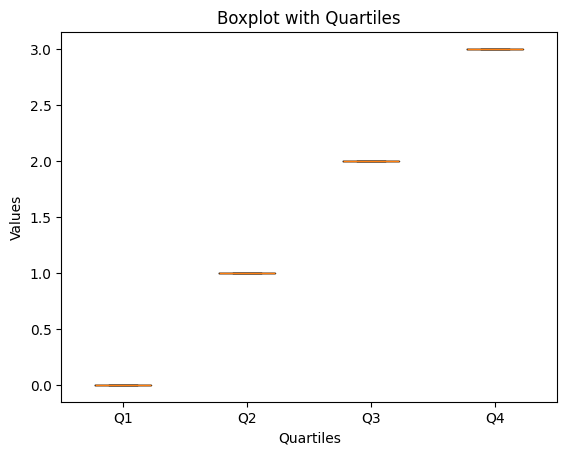


--------------------------------------

Histogramas para a coluna frequencia_atividade_fisica_int com log: False e bins: 100
frequencia_atividade_fisica_int <= 3.0


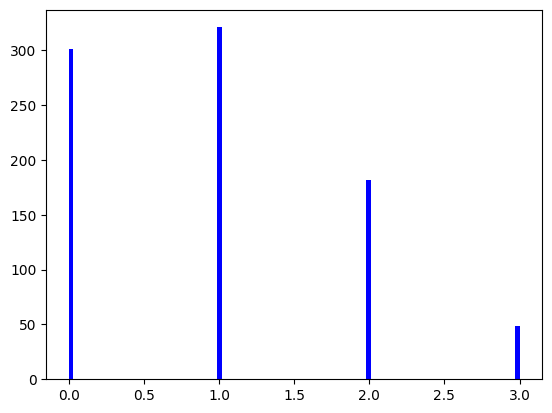


--------------------------------------

frequencia_atividade_fisica_int <= 2.0


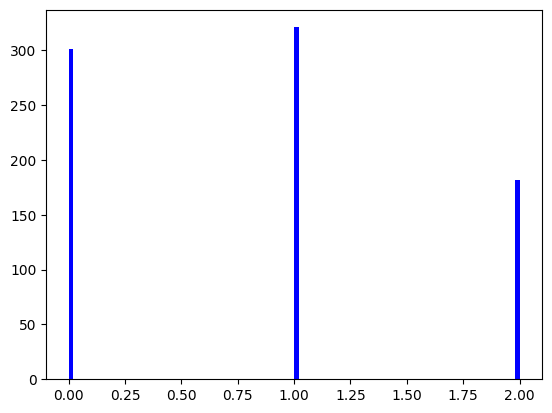


--------------------------------------

frequencia_atividade_fisica_int <= 1.0


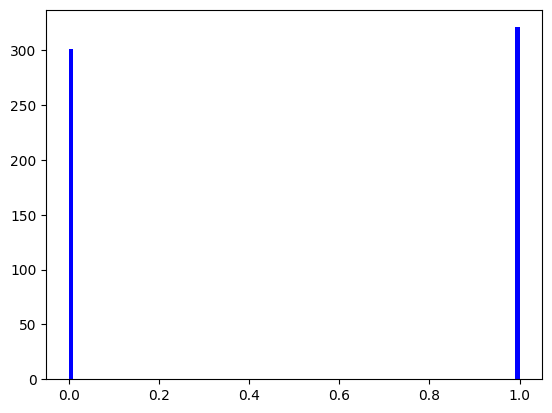


--------------------------------------

frequencia_atividade_fisica_int <= 0.0


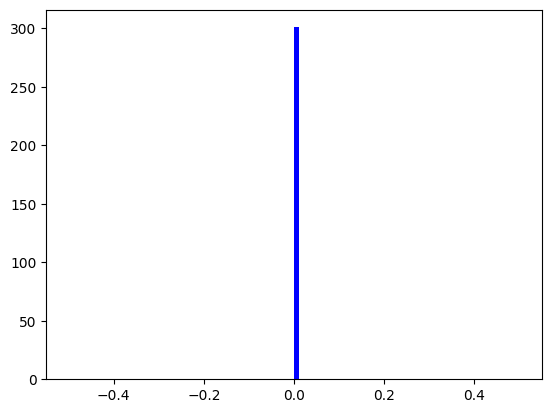


--------------------------------------


--------------------------------------

métricas gerais para tempo_usando_eletronicos
média: 0.6805139580304808
mediana: 0.655558
desvio padrão: 0.6194823315822622
kurtosis: -0.6480089390961297
skewness: 0.5756575665732485

--------------------------------------



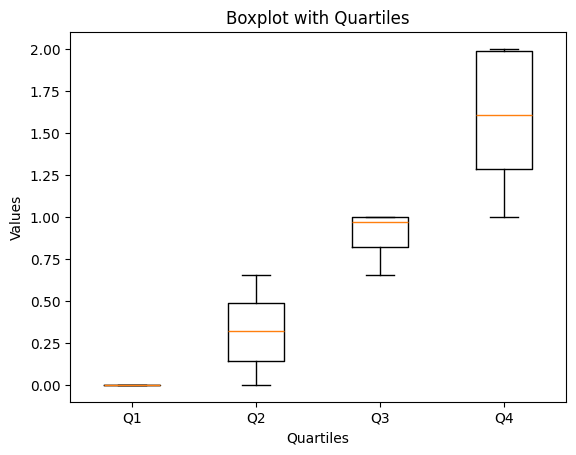


--------------------------------------

Histogramas para a coluna tempo_usando_eletronicos com log: False e bins: 100
tempo_usando_eletronicos <= 2.0


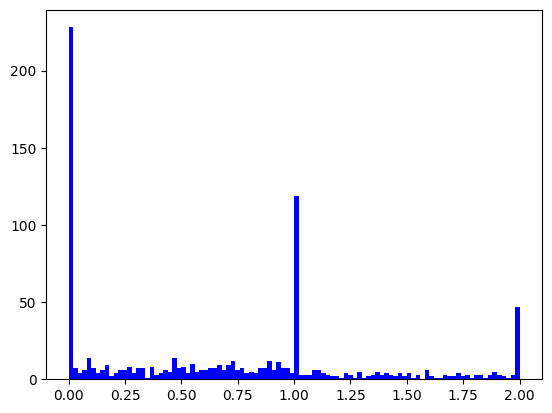


--------------------------------------

tempo_usando_eletronicos <= 1.0


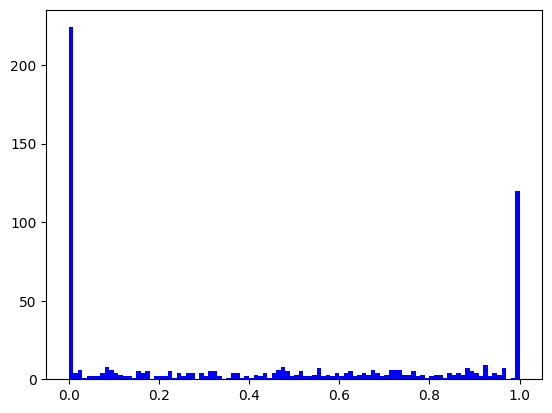


--------------------------------------

tempo_usando_eletronicos <= 0.655558


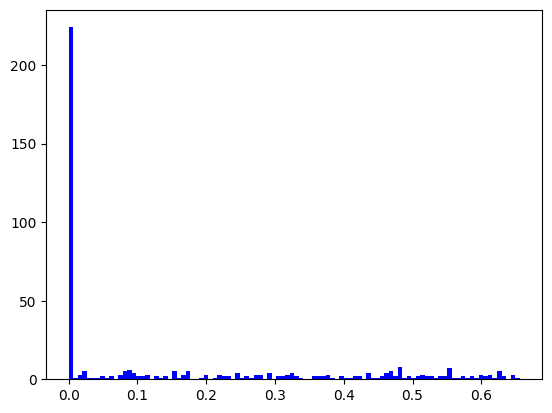


--------------------------------------

tempo_usando_eletronicos <= 0.0


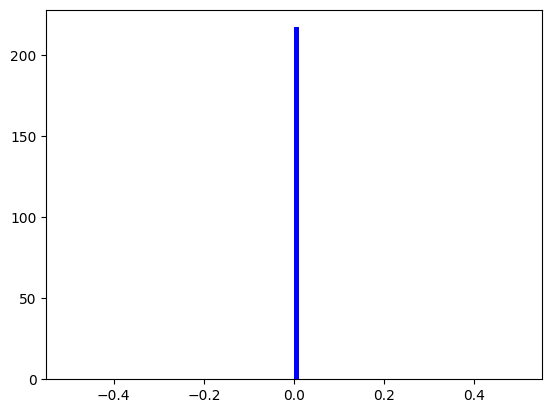


--------------------------------------


--------------------------------------

métricas gerais para tempo_usando_eletronicos_int
média: 0.6822977725674091
mediana: 1.0
desvio padrão: 0.6825307576740326
kurtosis: -0.8067484934686959
skewness: 0.4973191468470003

--------------------------------------



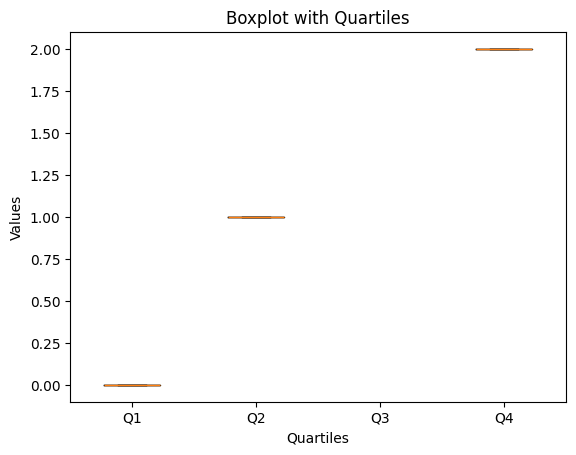


--------------------------------------

Histogramas para a coluna tempo_usando_eletronicos_int com log: False e bins: 100
tempo_usando_eletronicos_int <= 2.0


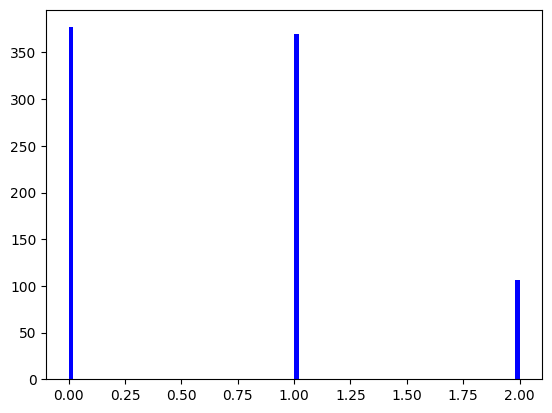


--------------------------------------

tempo_usando_eletronicos_int <= 1.0


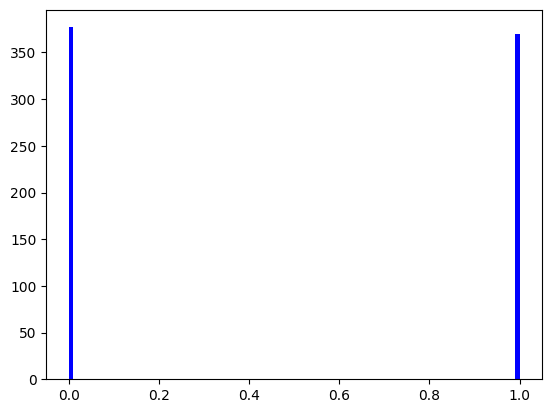


--------------------------------------

tempo_usando_eletronicos_int <= 1.0


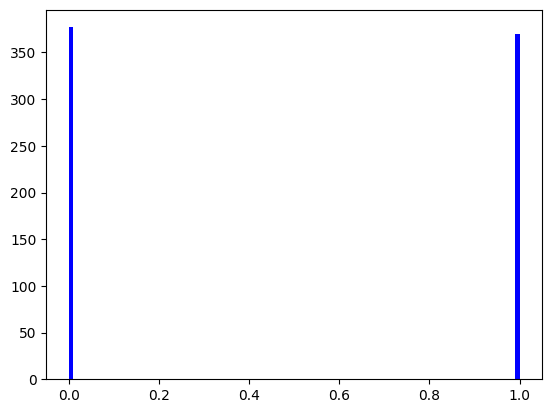


--------------------------------------

tempo_usando_eletronicos_int <= 0.0


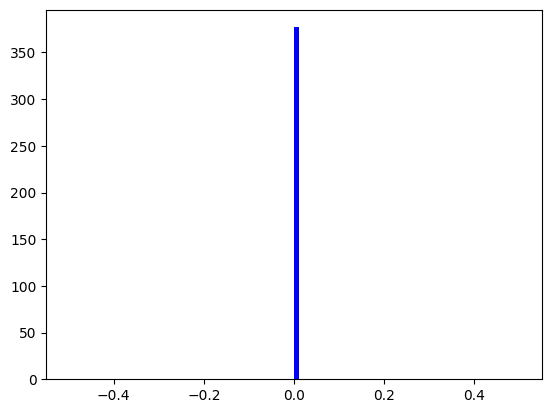


--------------------------------------


--------------------------------------

métricas gerais para IMC
média: 30.261439187792426
mediana: 30.119375573921033
desvio padrão: 8.056912202558362
kurtosis: -0.8763447413744183
skewness: 0.027278119729714948

--------------------------------------



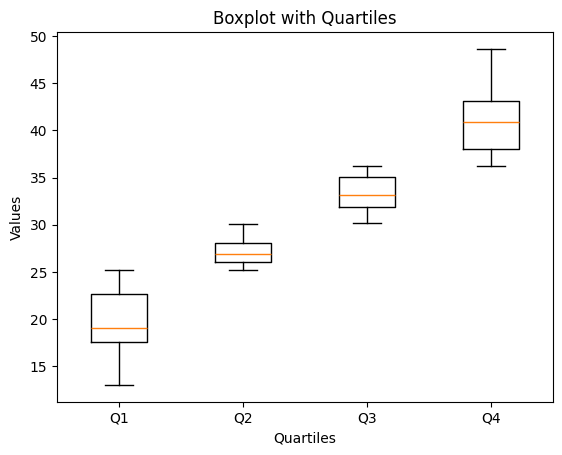


--------------------------------------

Histogramas para a coluna IMC com log: False e bins: 100
IMC <= 48.65169258051864


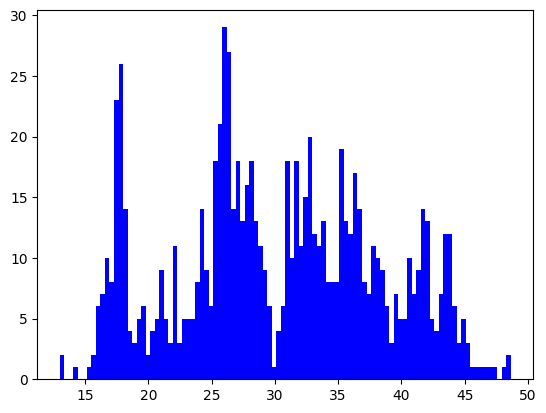


--------------------------------------

IMC <= 36.26502031183218


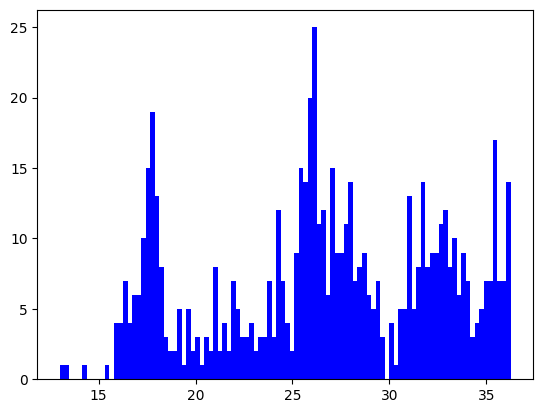


--------------------------------------

IMC <= 30.119375573921033


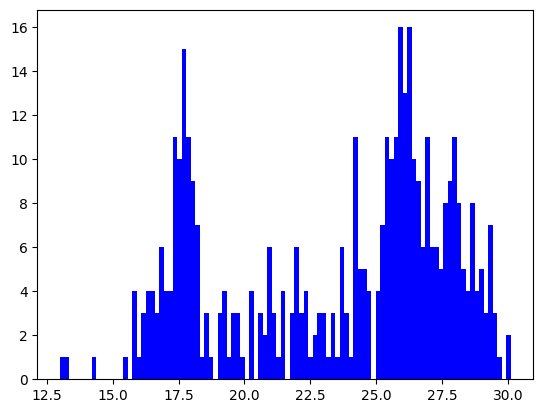


--------------------------------------

IMC <= 25.20808561236623


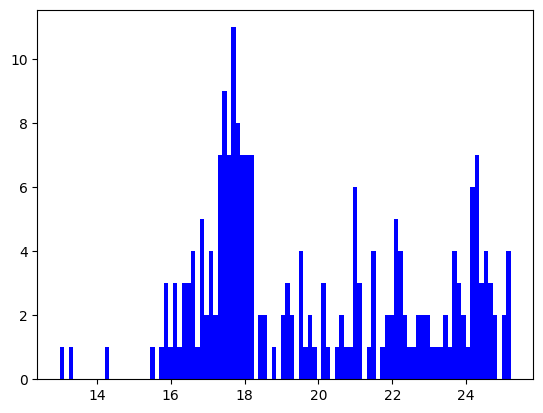


--------------------------------------



In [212]:
for row in numerical_columns:
  analyze_numerical_column(df[row]) 

## Gráficos categorias 

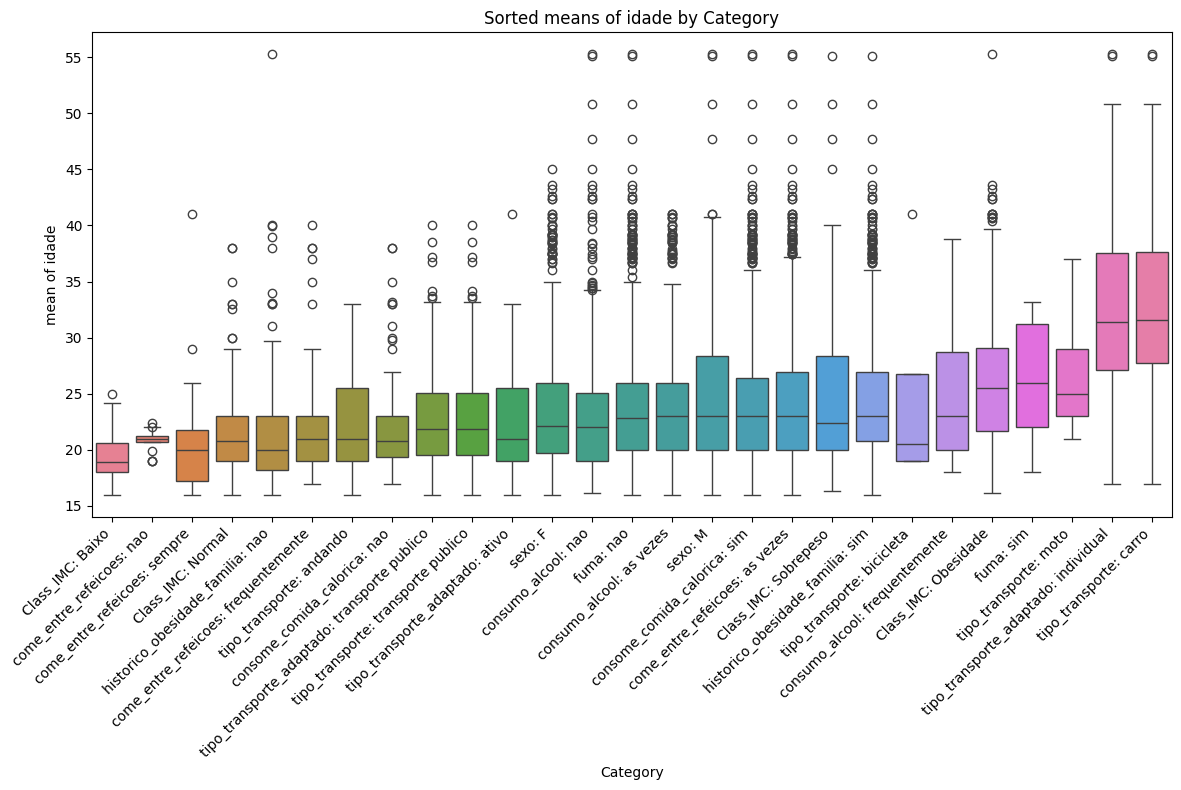

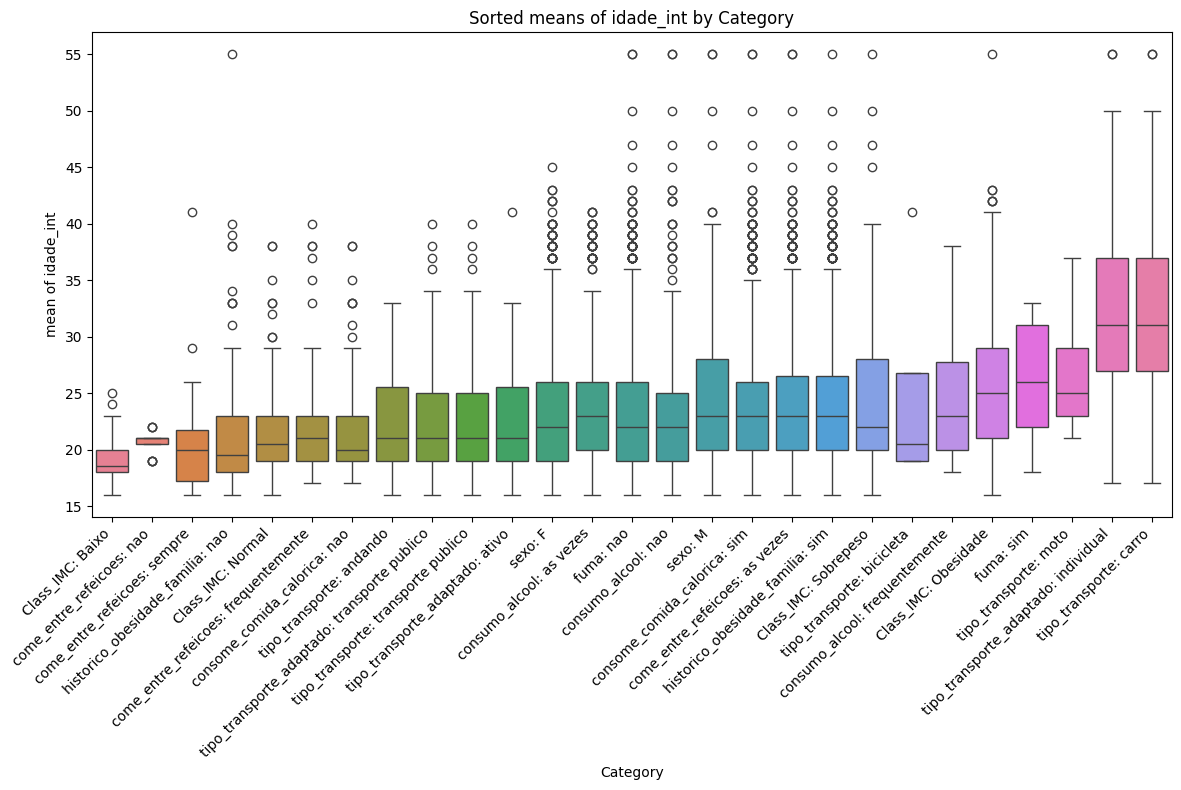

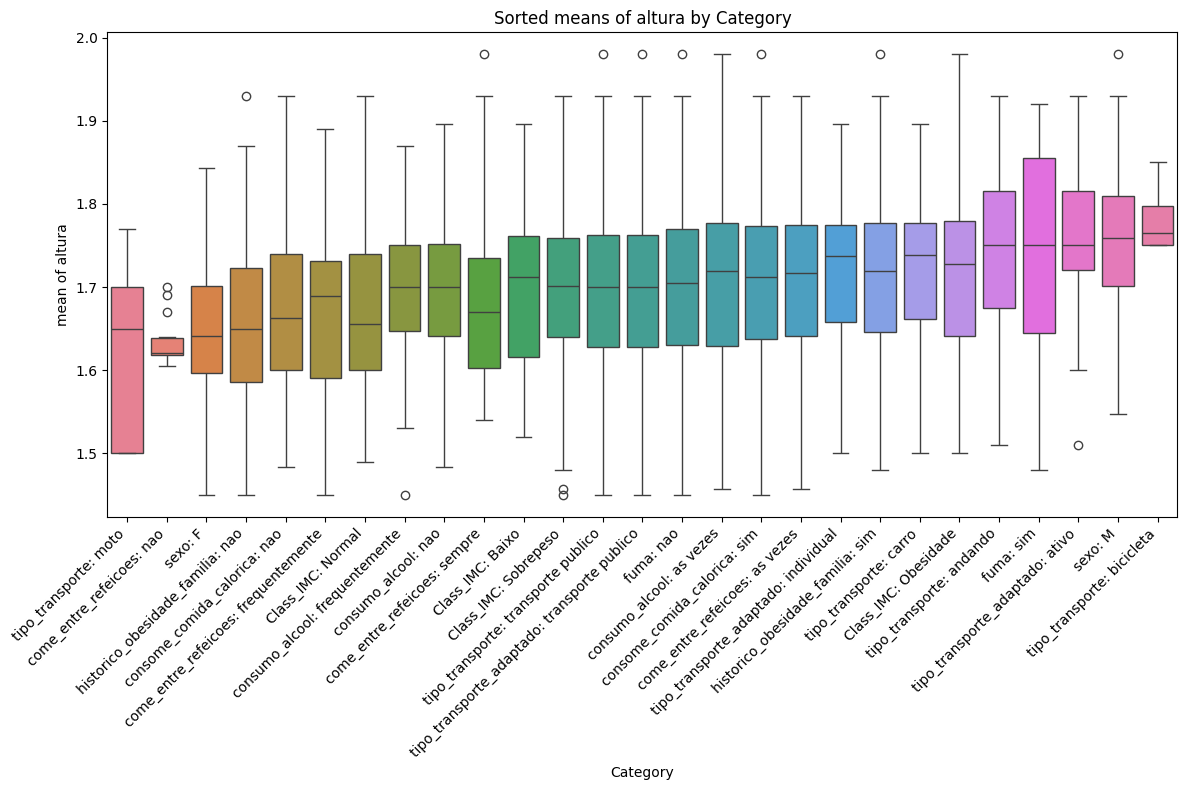

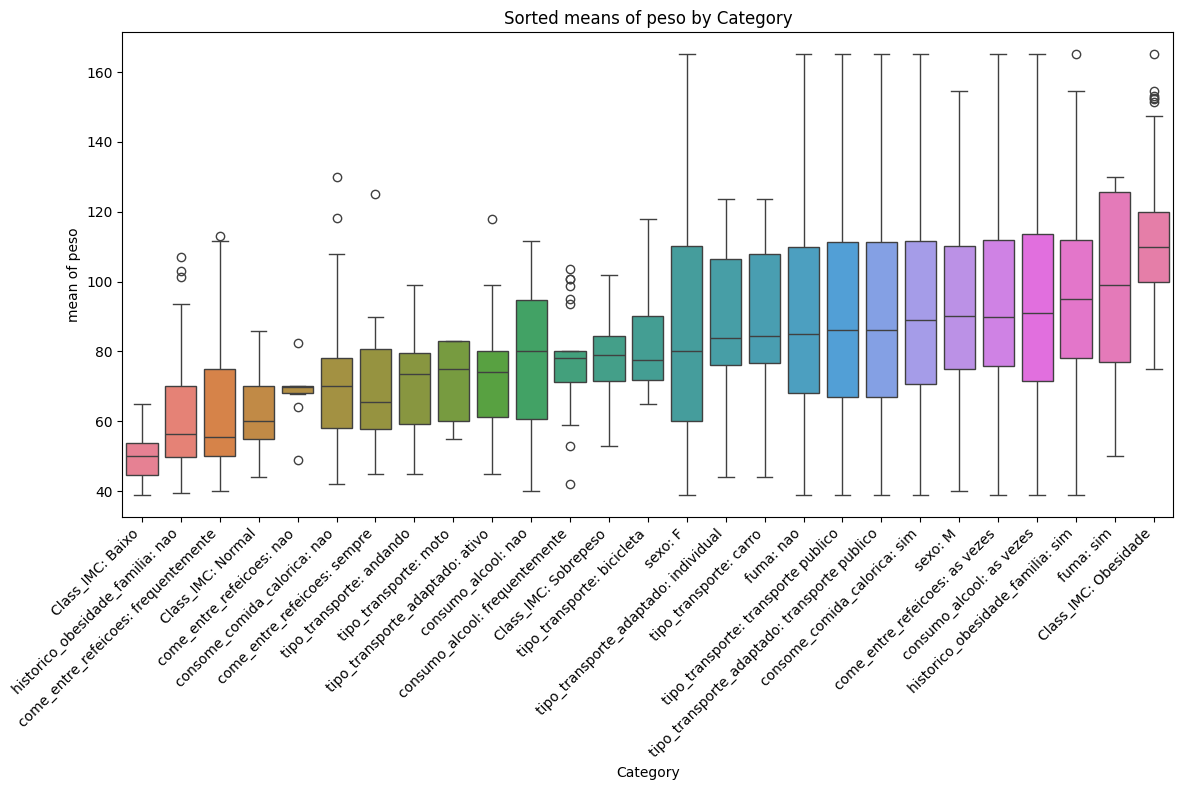

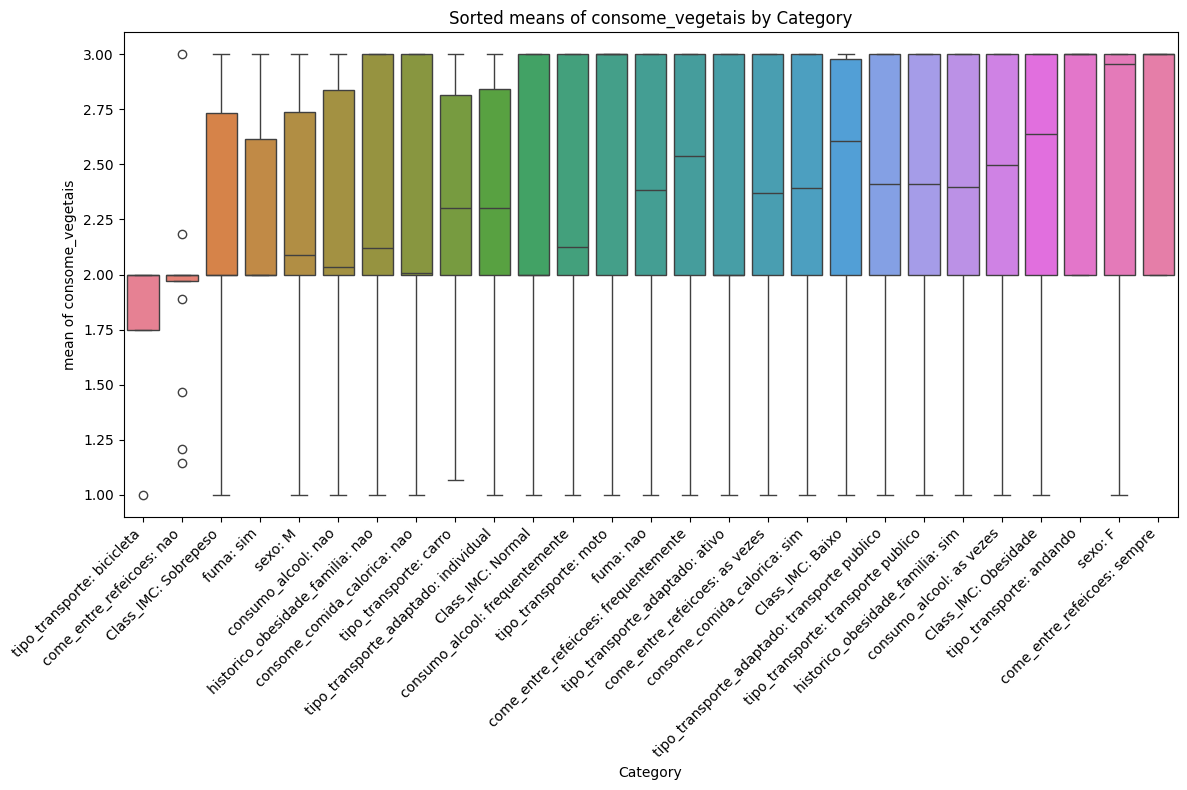

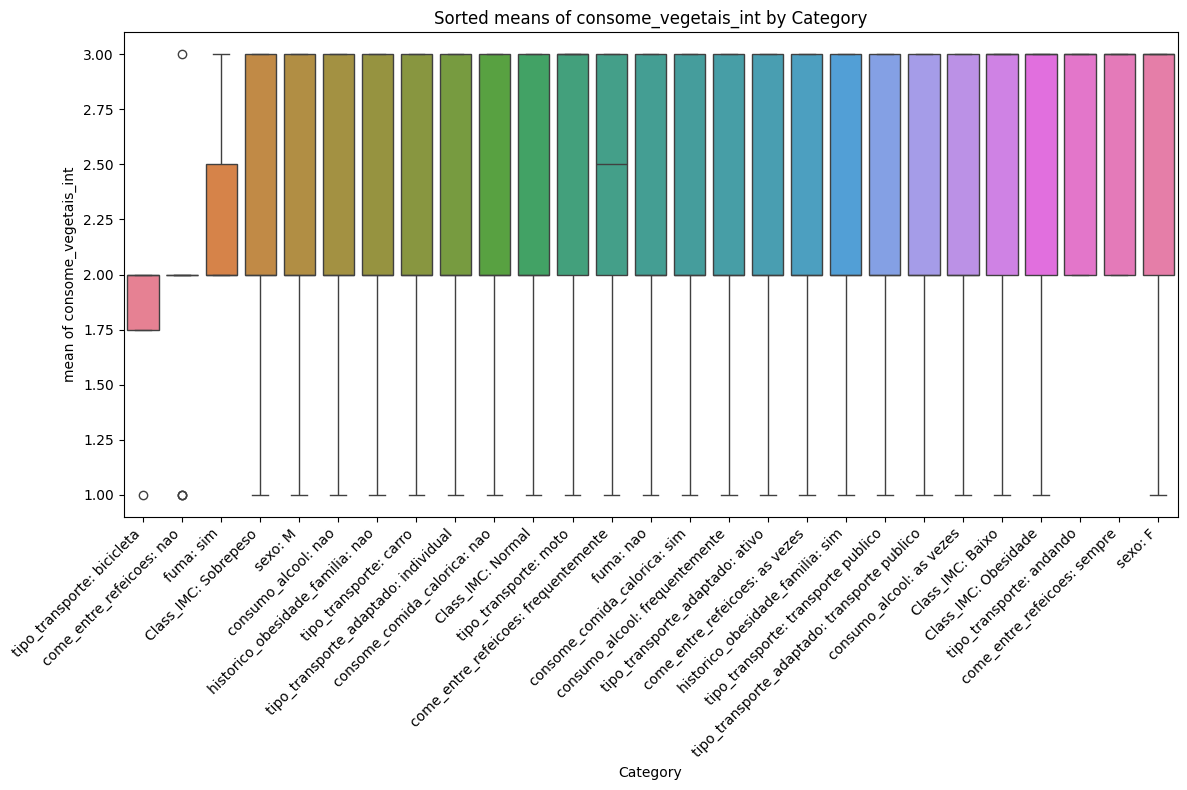

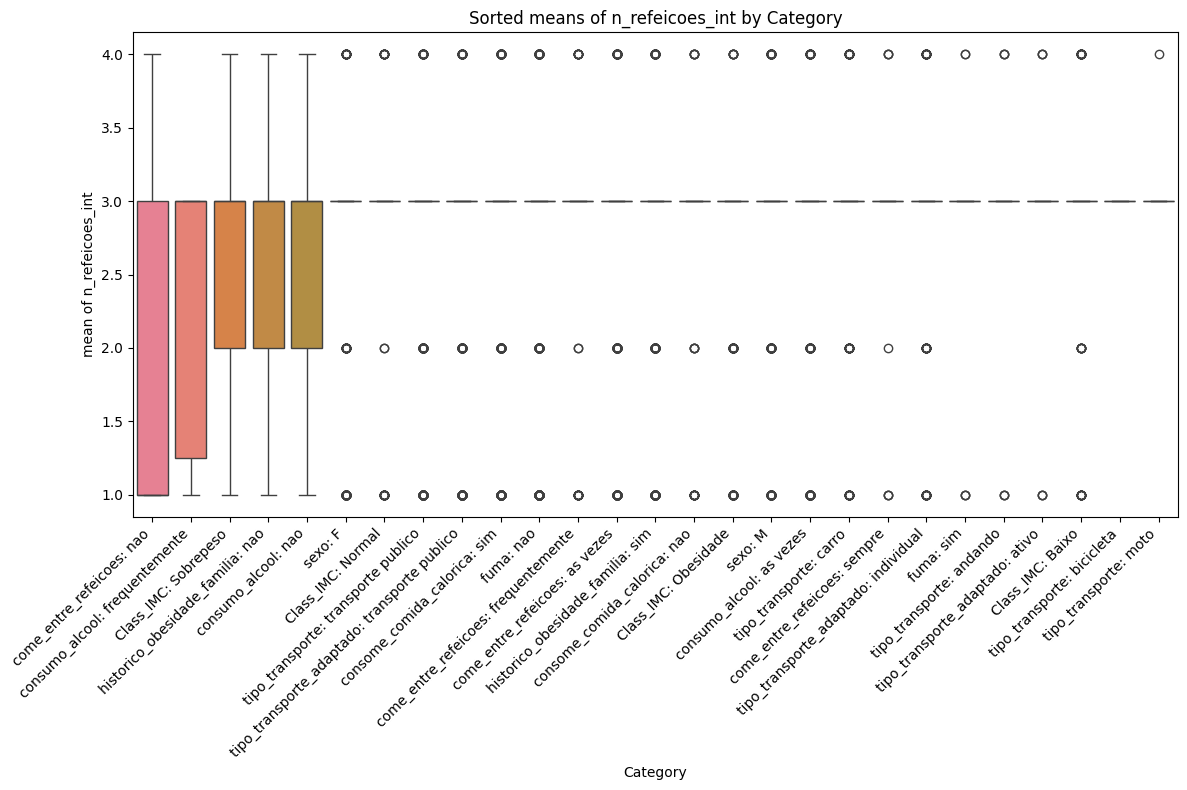

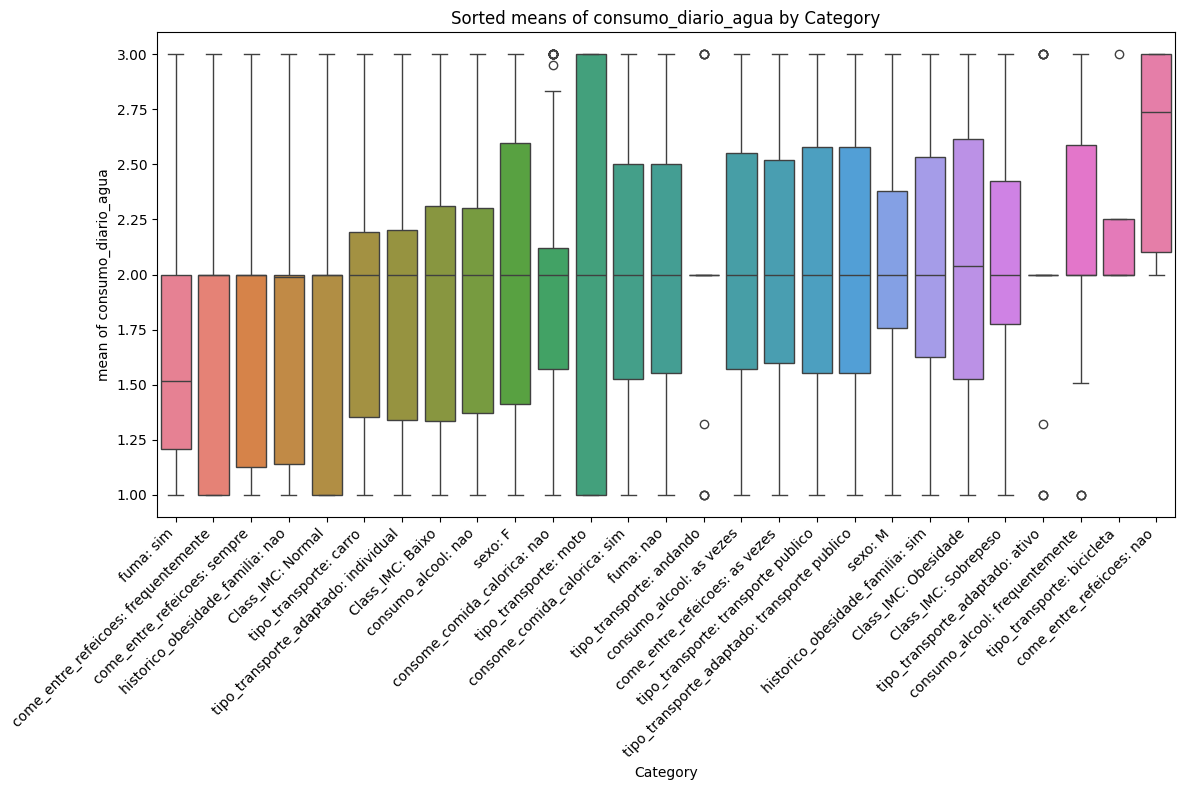

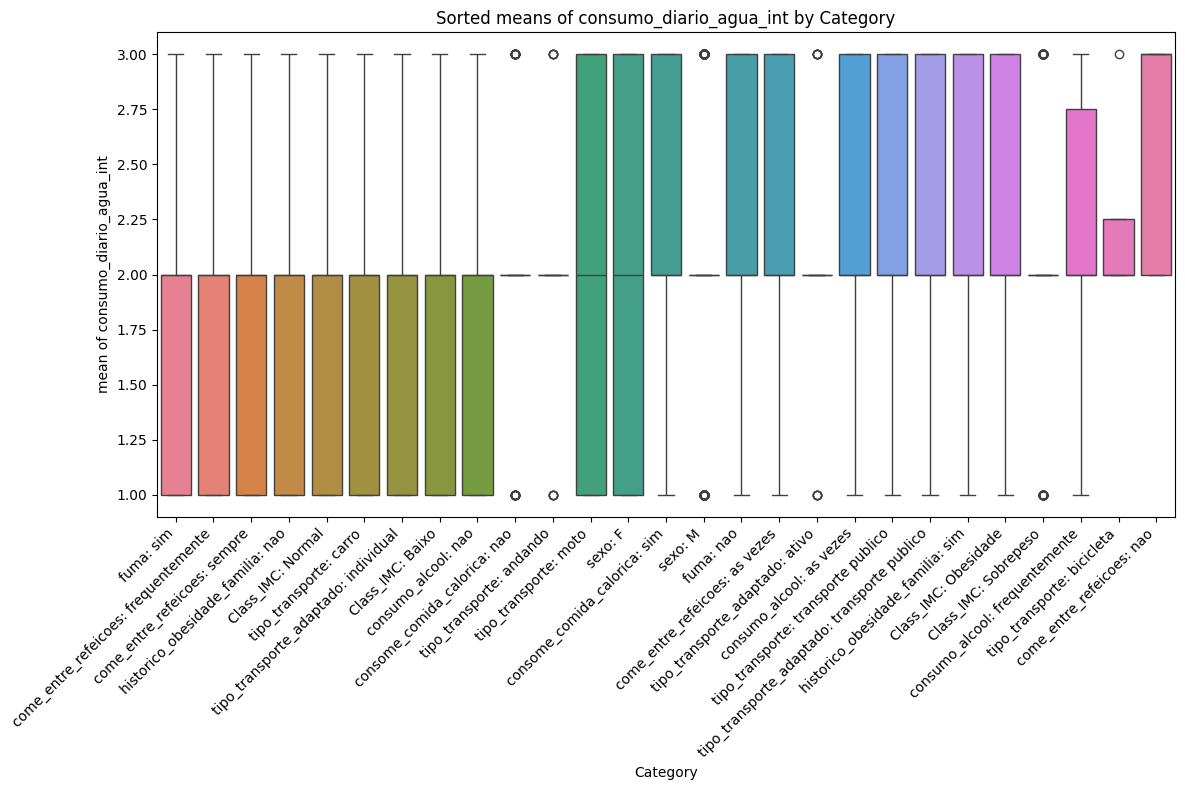

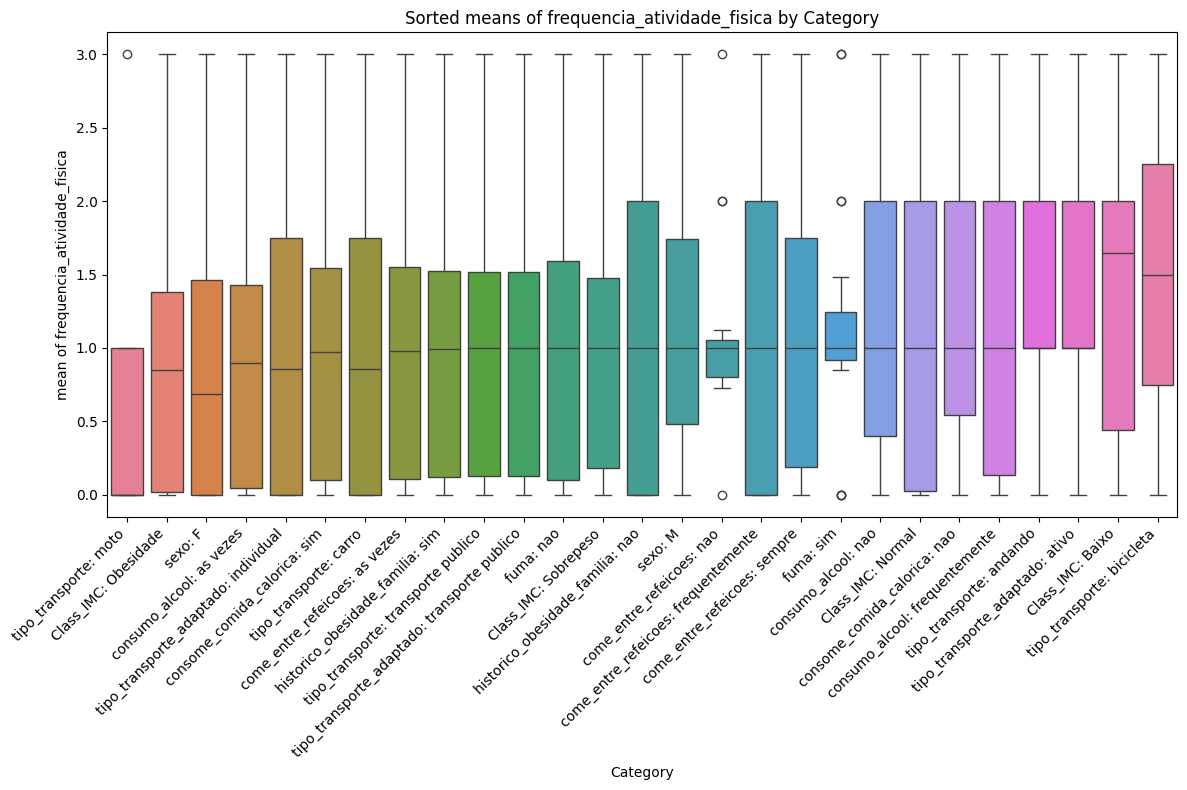

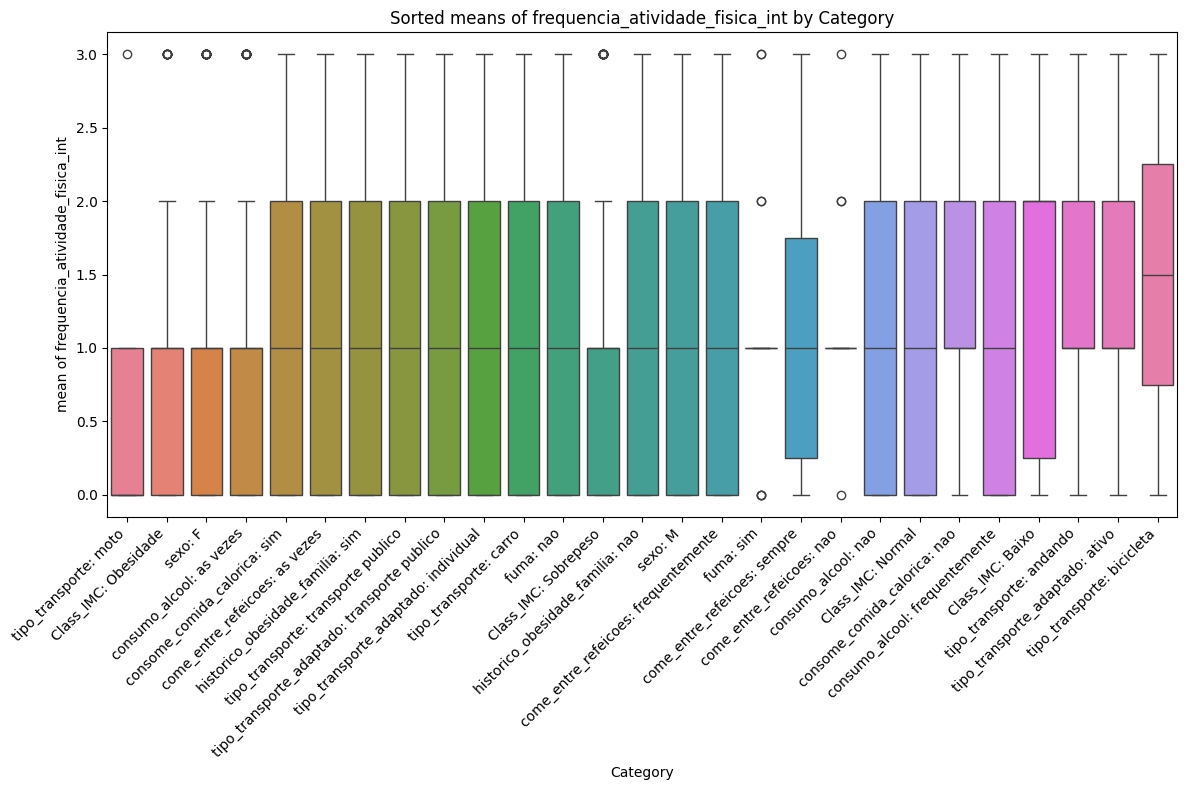

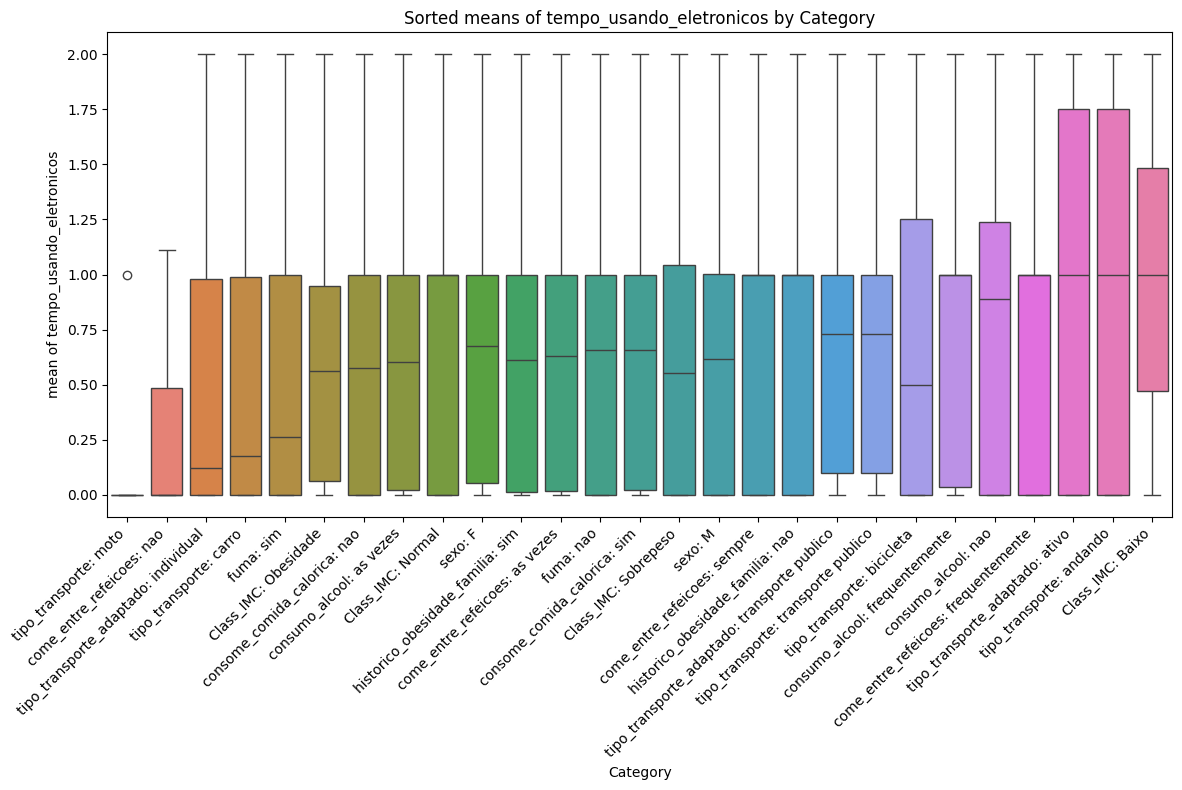

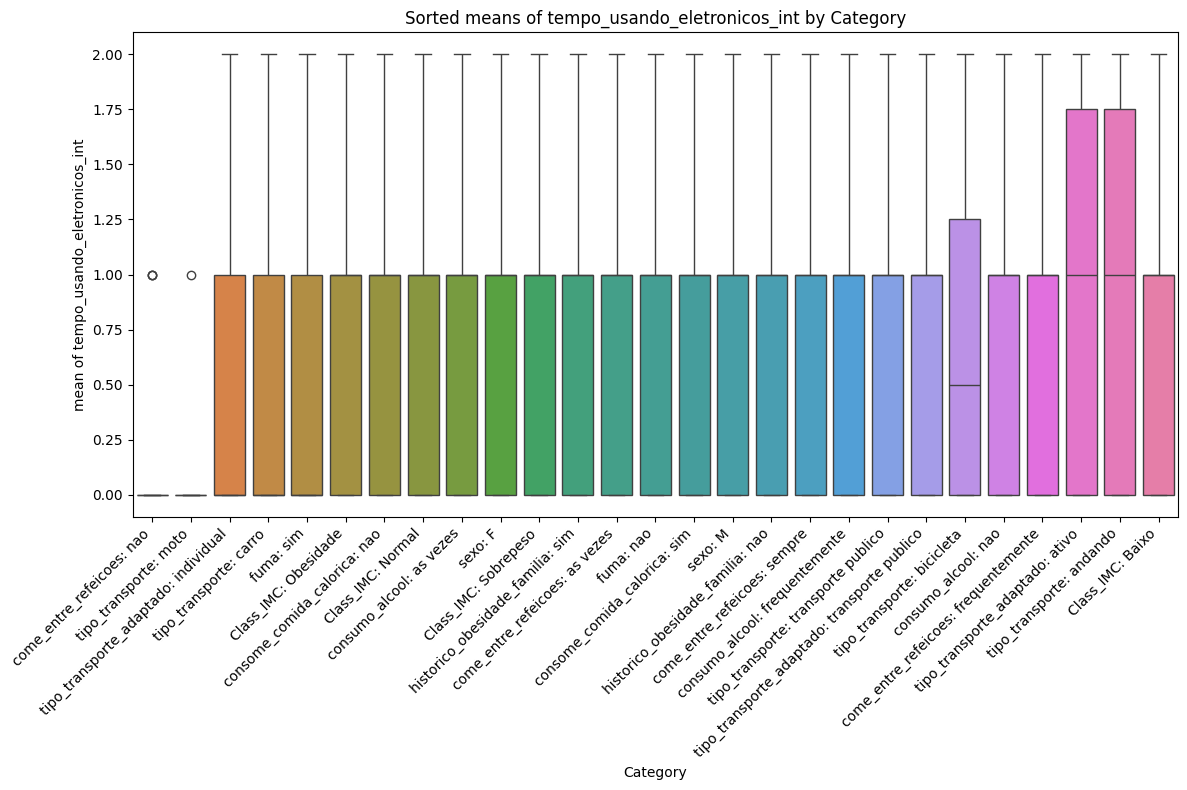

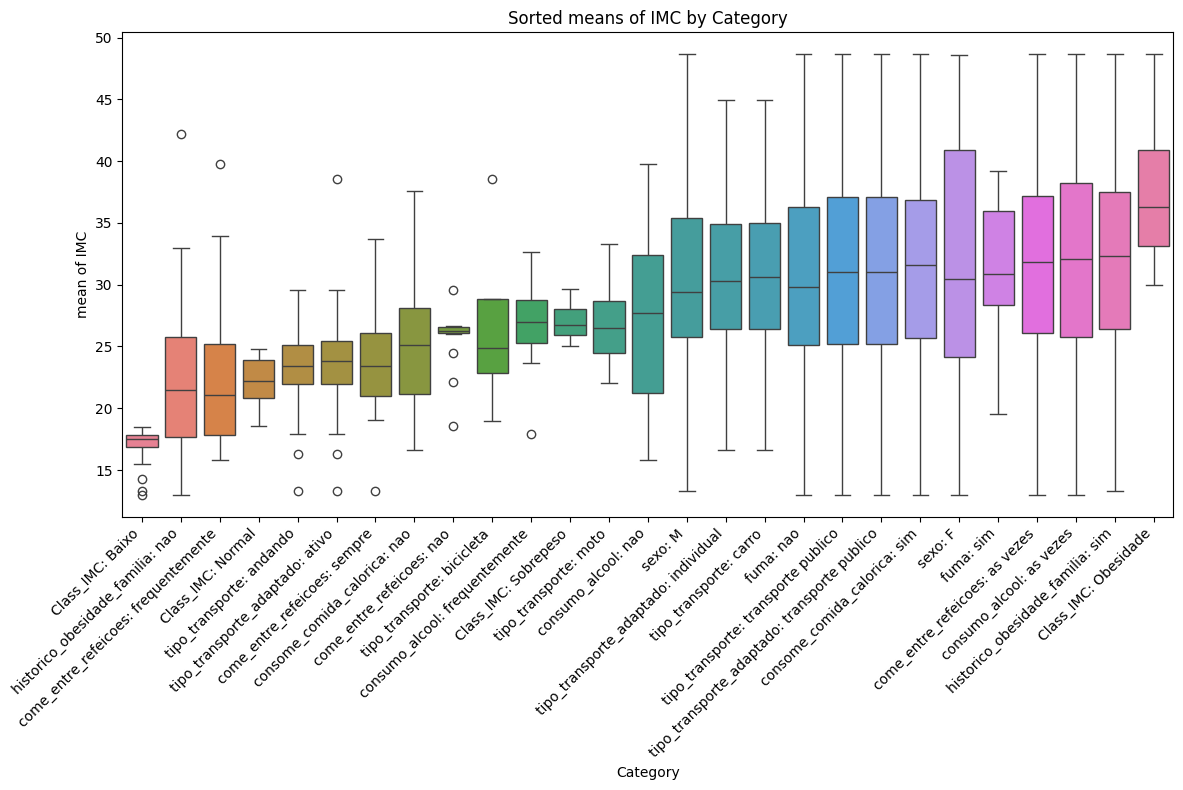

In [213]:
result_df = calculate_group_metric(df, category_columns, numerical_columns, metric='mean')
plot_sorted_group_metric(result_df, numerical_columns, metric='mean')

## Análise de correlação com spearmann

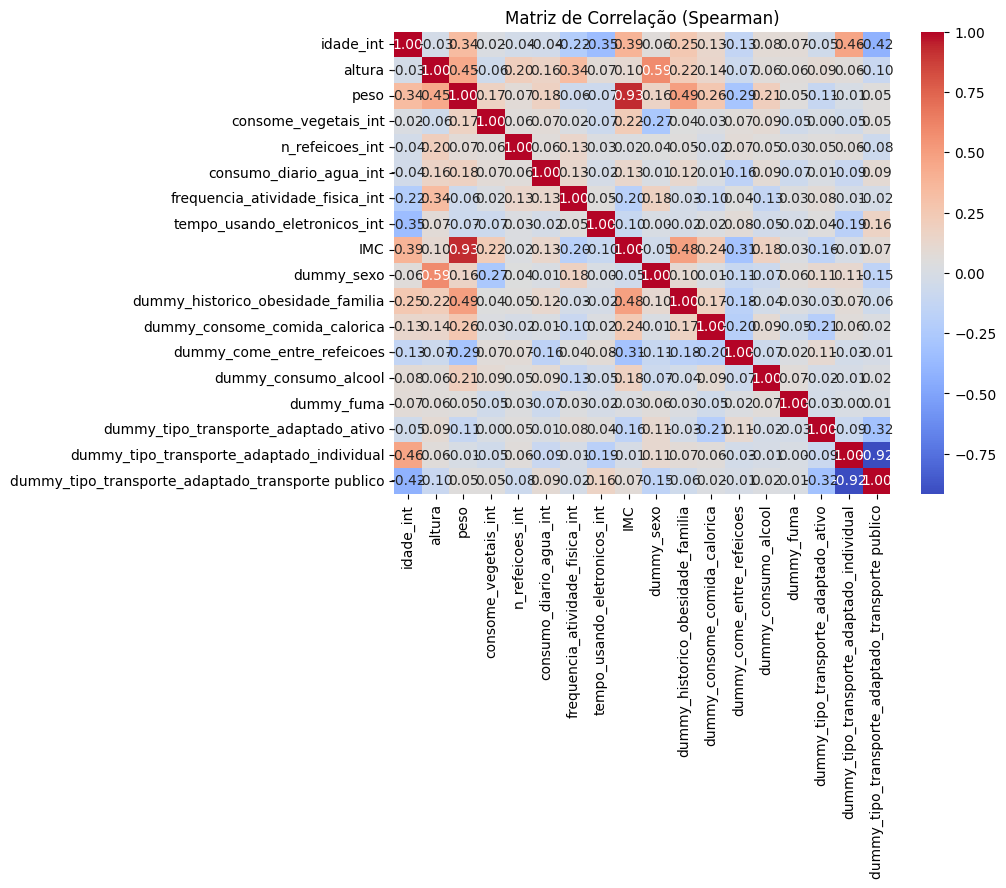

Variable 1  \
0                                         peso   
2    dummy_tipo_transporte_adaptado_individual   
4                                   dummy_sexo   
6                                         peso   
8            dummy_historico_obesidade_familia   
..                                         ...   
296                                 dummy_sexo   
298                    consumo_diario_agua_int   
300               tempo_usando_eletronicos_int   
302                       consome_vegetais_int   
304                                 dummy_fuma   

                                            Variable 2  Correlation  
0                                                  IMC     0.925276  
2    dummy_tipo_transporte_adaptado_transporte publico    -0.915937  
4                                               altura     0.587419  
6                    dummy_historico_obesidade_familia     0.491608  
8                                                  IMC     0.484804  
..                                                 ...          ...  
296                            consumo_diario_agua_int     0.006839  
298               dummy_tipo_transporte_adaptado_ativo     0.006825  
300                                         dummy_sexo     0.004046  
302               dummy_tipo_transporte_adaptado_ativo     0.000799  
304          dummy_tipo_transporte_adaptado_individual     0.000688  

[153 rows x 3 columns]

In [214]:
sorted_corr, corr_matrix = plot_and_return_correlation(df, category_columns_dummies=category_columns_dummies, numeric_columns=['idade_int', 'altura', 'peso', 'consome_vegetais_int', 'n_refeicoes_int', 'consumo_diario_agua_int', 'frequencia_atividade_fisica_int', 'tempo_usando_eletronicos_int', 'IMC'], method='spearman')
sorted_corr

# analise de influencia de colunas int para correlação

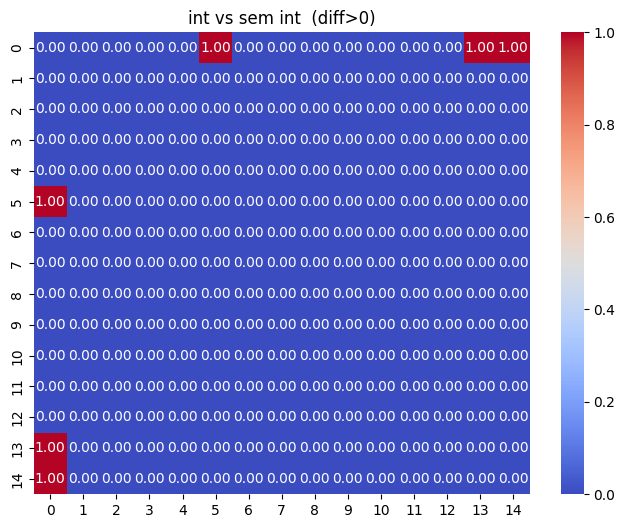

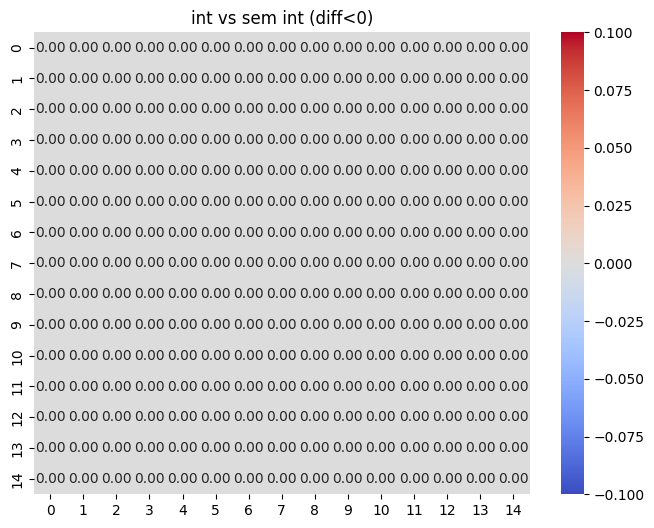

In [215]:
sorted_corr, corr_matrix = plot_and_return_correlation(df, category_columns_dummies=category_columns_dummies,
                            numeric_columns=['idade_int', 'consome_vegetais_int', 'n_refeicoes_int',
                                             'consumo_diario_agua_int', 'frequencia_atividade_fisica_int',
                                             'tempo_usando_eletronicos_int'], method='spearman', plot=False)

sorted_corr2, corr_matrix2 = plot_and_return_correlation(df, category_columns_dummies=category_columns_dummies,
                                                       numeric_columns=['idade', 'consome_vegetais', 'n_refeicoes', 'consumo_diario_agua','frequencia_atividade_fisica', 'tempo_usando_eletronicos'],
                                                       method='spearman', plot=False)


diff = abs(corr_matrix.to_numpy()) - abs(corr_matrix2.to_numpy())
mask1 = (abs(corr_matrix.to_numpy()) >= 0.3) & (diff > 0)
plt.figure(figsize=(8, 6))
sns.heatmap(mask1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'int vs sem int  (diff>0)')
plt.show()


mask2 = (abs(corr_matrix.to_numpy()) >= 0.3) & (diff < 0)
plt.figure(figsize=(8, 6))
sns.heatmap(mask2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'int vs sem int (diff<0)')
plt.show()


# começando analises para agrupamento

In [216]:
numerical_columns_clustering_refinado = ['idade_int', 'consome_vegetais_int', 'n_refeicoes_int', 'consumo_diario_agua_int', 'frequencia_atividade_fisica_int', 'IMC'] 
numerical_columns_clustering = ['idade', 'consome_vegetais', 'n_refeicoes', 'consumo_diario_agua', 'frequencia_atividade_fisica', 'tempo_usando_eletronicos', 'IMC', 'peso', 'altura']

category_columns_clustering_refinado = [
  'dummy_sexo',
  'dummy_historico_obesidade_familia',
  'dummy_consome_comida_calorica',
  'dummy_come_entre_refeicoes',
  'dummy_consumo_alcool',
  'dummy_fuma',
  'dummy_tipo_transporte_adaptado_ativo',
  'dummy_tipo_transporte_adaptado_individual',
  'dummy_tipo_transporte_adaptado_transporte publico'
]

category_columns_clustering = [
  'dummy_sexo',
  'dummy_historico_obesidade_familia',
  'dummy_consome_comida_calorica',
  'dummy_come_entre_refeicoes',
  'dummy_consumo_alcool',
  'dummy_fuma',
  'dummy_tipo_transporte_andando', 
  'dummy_tipo_transporte_bicicleta',
  'dummy_tipo_transporte_carro', 
  'dummy_tipo_transporte_moto',
  'dummy_tipo_transporte_transporte publico'
]

print(f"dimensionalidade: {len(numerical_columns_clustering + category_columns_clustering)}")

scaled_df = scale_data(df, list(set(numerical_columns_clustering + category_columns_clustering_refinado + numerical_columns_clustering_refinado + category_columns_clustering)))
scaled_df

dimensionalidade: 20


idade    altura      peso  consome_vegetais  n_refeicoes  \
0     1.122120  1.045574  0.099785         -0.411082     0.408802   
1    -0.541862 -0.894823 -0.704480         -0.795750    -2.244845   
2    -1.025015 -0.032559 -1.465166         -1.554411     0.984521   
3     0.255472 -0.881780  0.632132          1.106782     0.408802   
4     1.403439 -1.212697 -1.086513          1.106782    -2.244845   
...        ...       ...       ...               ...          ...   
1091  0.268680 -0.675013  0.858787          1.106782     0.408802   
1092  0.268680 -0.047160 -0.704480          1.106782    -2.244845   
1094 -1.352404 -1.424613 -1.506750         -0.795750     1.735625   
1097  1.135448  1.261898  1.452515          0.990349     0.408802   
1099 -0.796417  1.156173 -0.087691          0.427926     1.498735   

      consumo_diario_agua  frequencia_atividade_fisica  \
0               -1.296652                    -0.397135   
1                1.622462                     0.019926   
2               -1.530925                    -0.193358   
3                0.304978                    -0.995968   
4                0.001167                    -1.160192   
...                   ...                          ...   
1091             1.081238                    -1.160192   
1092             0.001167                     1.200044   
1094            -0.817819                    -1.160192   
1097            -0.843537                    -0.042900   
1099             0.645022                     1.252164   

      tempo_usando_eletronicos sexo historico_obesidade_familia  ...  \
0                    -0.835356    M                         sim  ...   
1                    -1.099165    M                         nao  ...   
2                     0.565859    F                         nao  ...   
3                     0.049776    F                         sim  ...   
4                    -1.099165    F                         nao  ...   
...                        ...  ...                         ...  ...   
1091                 -0.651905    F                         sim  ...   
1092                 -1.099165    M                         sim  ...   
1094                  0.516033    F                         nao  ...   
1097                  1.098252    M                         sim  ...   
1099                 -0.337336    M                         sim  ...   

     dummy_tipo_transporte_carro dummy_tipo_transporte_moto  \
0                      -0.504392                  -0.076787   
1                      -0.504392                  -0.076787   
2                      -0.504392                  -0.076787   
3                      -0.504392                  -0.076787   
4                      -0.504392                  -0.076787   
...                          ...                        ...   
1091                   -0.504392                  -0.076787   
1092                   -0.504392                  -0.076787   
1094                   -0.504392                  -0.076787   
1097                   -0.504392                  -0.076787   
1099                   -0.504392                  -0.076787   

     dummy_tipo_transporte_transporte publico  \
0                                    0.560651   
1                                    0.560651   
2                                    0.560651   
3                                    0.560651   
4                                    0.560651   
...                                       ...   
1091                                 0.560651   
1092                                 0.560651   
1094                                 0.560651   
1097                                 0.560651   
1099                                 0.560651   

     dummy_tipo_transporte_adaptado_ativo  \
0                                -0.17731   
1                                -0.17731   
2                                -0.17731   
3                                -0.17731   
4                                -0.17731   
..

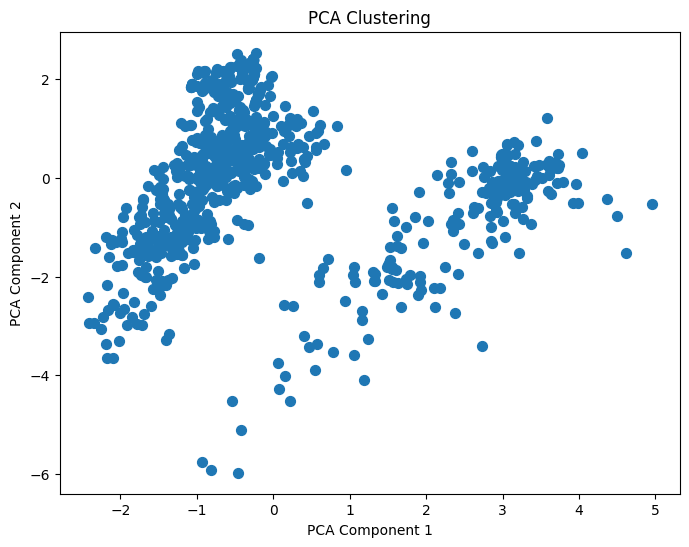

contribuiçoes de cada pca: [0.1668 0.139  0.0935 0.0873 0.0729]


{'PCA1': {'dummy_tipo_transporte_adaptado_individual': np.float64(0.569877057980967),
  'dummy_tipo_transporte_adaptado_transporte publico': np.float64(0.5561340831842755),
  'idade_int': np.float64(0.5090590692664216),
  'dummy_historico_obesidade_familia': np.float64(0.18687787703242895),
  'IMC': np.float64(0.13585276603723817)},
 'PCA2': {'IMC': np.float64(0.5448101974799202),
  'dummy_historico_obesidade_familia': np.float64(0.35922698898076727),
  'dummy_consome_comida_calorica': np.float64(0.33593430294371185),
  'dummy_come_entre_refeicoes': np.float64(0.33213087663193697),
  'dummy_tipo_transporte_adaptado_ativo': np.float64(0.28772786501125797)},
 'PCA3': {'dummy_sexo': np.float64(0.5030600160720061),
  'frequencia_atividade_fisica_int': np.float64(0.4763132261367155),
  'consumo_diario_agua_int': np.float64(0.4169821276028425),
  'dummy_historico_obesidade_familia': np.float64(0.3122333628092947),
  'n_refeicoes_int': np.float64(0.29771952803137147)},
 'PCA4': {'consome_vege

In [217]:
pca_analysis_df, loadings, pca_contributions = pca_analysis(scaled_df, columns=numerical_columns_clustering_refinado + category_columns_clustering_refinado)

print(f"contribuiçoes de cada pca: {pca_contributions}")
loadings

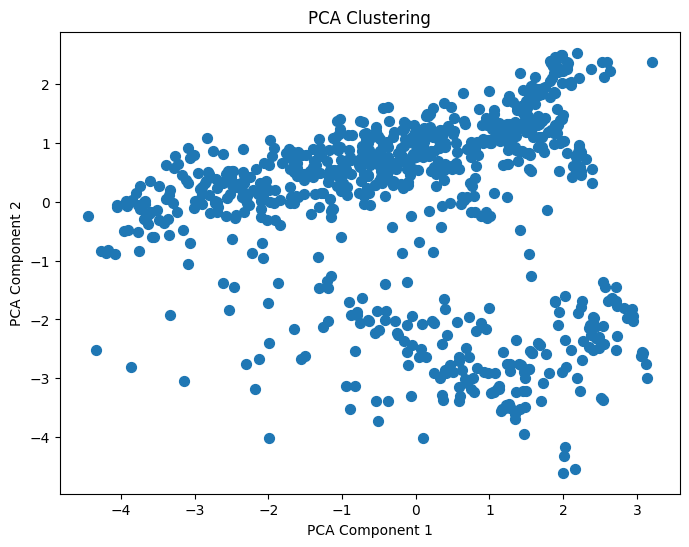

contribuiçoes de cada pca: [0.1532 0.1231 0.1012 0.0689 0.056 ]


{'PCA1': {'peso': np.float64(0.4964886862894247),
  'IMC': np.float64(0.46676527489669195),
  'dummy_historico_obesidade_familia': np.float64(0.3556419222783704),
  'idade': np.float64(0.2958754561039848),
  'dummy_come_entre_refeicoes': np.float64(0.23553096706152077)},
 'PCA2': {'dummy_tipo_transporte_transporte publico': np.float64(0.5714505295654527),
  'dummy_tipo_transporte_carro': np.float64(0.5378425838656601),
  'idade': np.float64(0.3982781535358053),
  'peso': np.float64(0.21681498623898918),
  'IMC': np.float64(0.20634305919220003)},
 'PCA3': {'altura': np.float64(0.5348029254349437),
  'dummy_sexo': np.float64(0.5010156546022373),
  'frequencia_atividade_fisica': np.float64(0.41043188528840174),
  'n_refeicoes': np.float64(0.2139712003626714),
  'consumo_diario_agua': np.float64(0.20154318843429733)},
 'PCA4': {'consome_vegetais': np.float64(0.5740136138995618),
  'dummy_come_entre_refeicoes': np.float64(0.361269207874892),
  'dummy_tipo_transporte_andando': np.float64(0.3

In [218]:
pca_analysis_df, loadings, pca_contributions = pca_analysis(scaled_df, columns=numerical_columns_clustering + category_columns_clustering)

print(f"contribuiçoes de cada pca: {pca_contributions}")
loadings

Baseado no gráfico, podemos remover o último pca sem problemas.


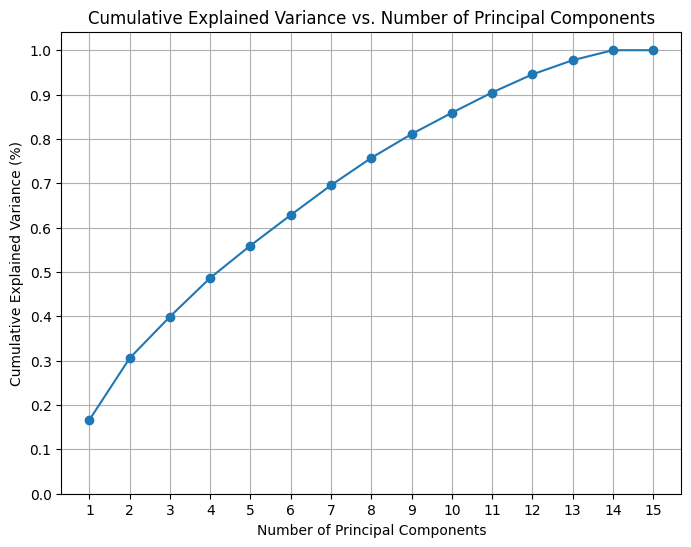

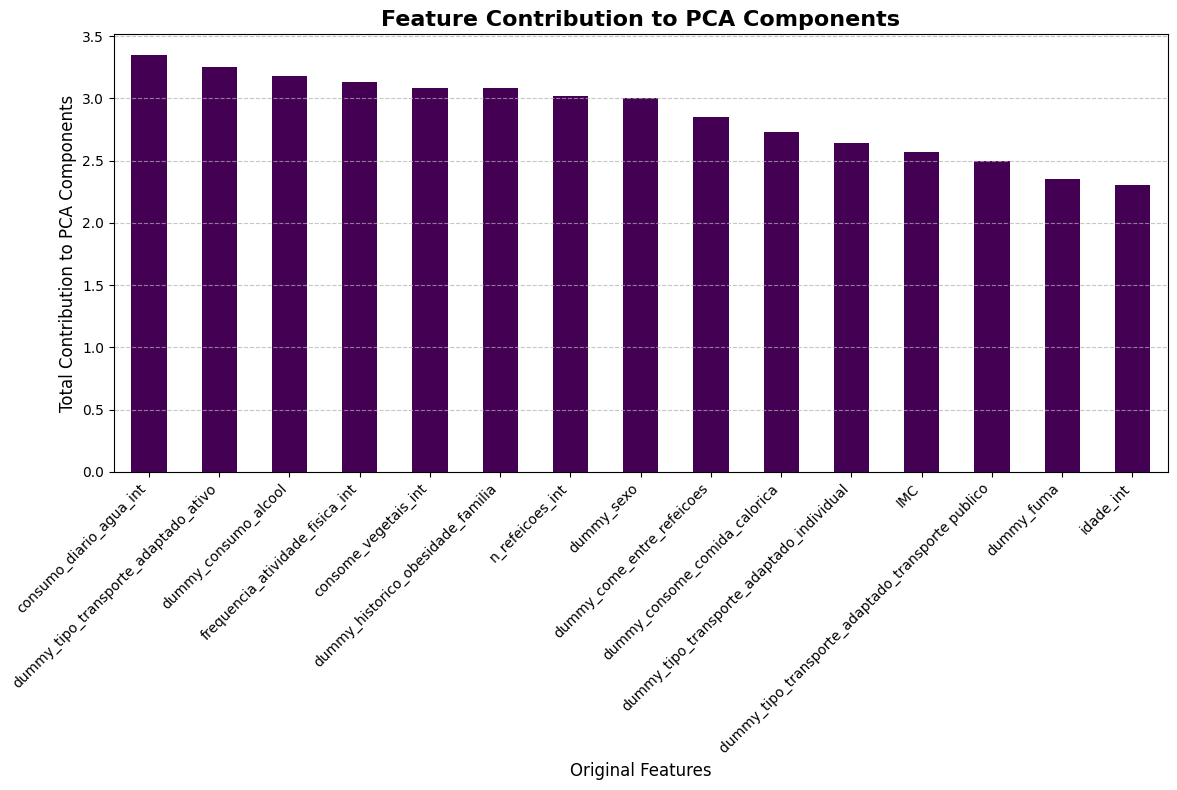

Baseado no gráfico, podemos remover o último pca sem problemas.


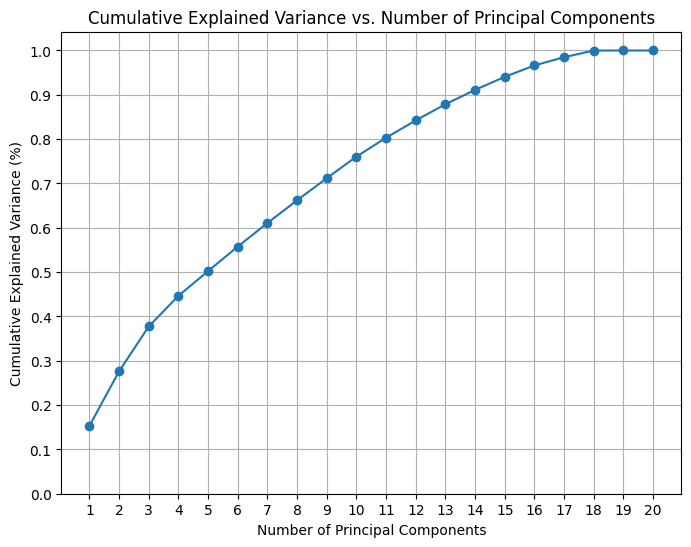

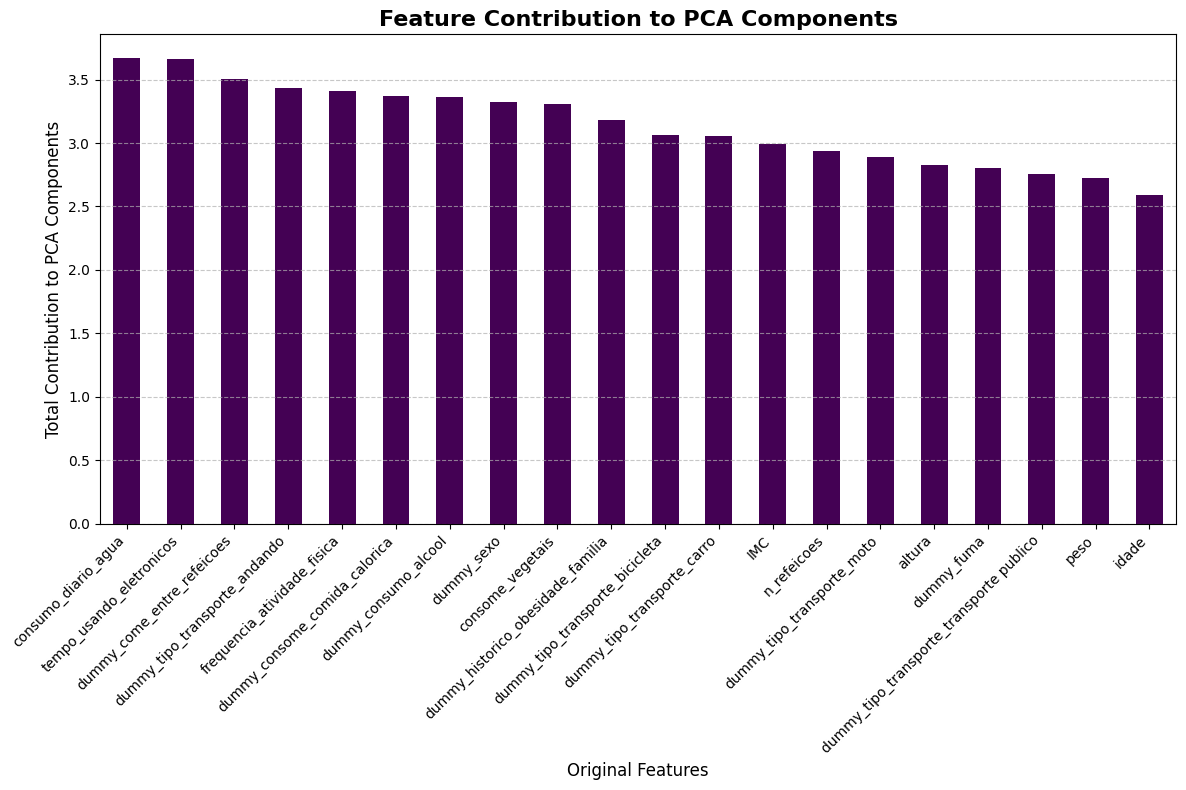

In [219]:
print("Baseado no gráfico, podemos remover o último pca sem problemas.")
cumulative_explained_variance, feature_contributions = pca_explained_variance_plot(df, columns=numerical_columns_clustering_refinado + category_columns_clustering_refinado)


print("Baseado no gráfico, podemos remover o último pca sem problemas.")
cumulative_explained_variance, feature_contributions = pca_explained_variance_plot(df, columns=numerical_columns_clustering + category_columns_clustering)

In [220]:
pca_df, loadings, pca_contributions = pca_analysis(scaled_df, columns=numerical_columns_clustering_refinado + category_columns_clustering_refinado, plot=False)

pca_df = pca_df[[f"pca{i}"for i in range(1, 14)]]
pca_df

pca1      pca2      pca3      pca4      pca5      pca6      pca7  \
0     0.353377  0.130006  0.067167 -1.209867  0.670044  0.246895 -0.254446   
1    -1.084646  0.268070  0.419787 -2.148419 -0.724044 -1.371216  2.694430   
2    -1.656641 -1.426095 -1.558435 -0.777409  0.273686 -1.493302  0.271401   
3    -0.283130  1.987003 -0.888134  0.955219  0.113142  0.371818 -0.013719   
4    -0.767895 -1.073104 -3.107390 -0.103564 -1.292834  0.528306 -0.365403   
...        ...       ...       ...       ...       ...       ...       ...   
1091 -0.277443  2.342798 -0.304206  1.319852 -0.148068  0.062705  0.426011   
1092 -1.048012 -1.305517 -0.410159  1.226854  1.090595  0.479970  1.155127   
1094 -2.096518 -2.561338 -2.696452  0.890074  1.166965 -0.861245 -1.068304   
1097  0.615988  1.078383  0.159164 -0.614261  5.821197  0.939678 -2.222067   
1099 -0.867017  0.156454  1.589488  0.753322  0.306594 -0.909743 -0.813763   

          pca8      pca9     pca10     pca11     pca12     pca13  
0     1.110745  0.290646 -0.266995 -0.838660 -0.458855  0.615382  
1    -1.758662  0.489484 -0.963956  0.039872  0.843888  0.528749  
2     0.855405  0.279675 -1.370639  0.342309 -0.597706 -0.094410  
3     0.394215 -0.194939 -0.382331  0.087918  0.128549  0.034677  
4    -1.229349  0.525243  0.965823  1.032846  1.312921  1.872731  
...        ...       ...       ...       ...       ...       ...  
1091 -0.059030 -0.629720  0.139990  0.622439  0.487625  0.273539  
1092 -1.733442  0.272641  2.449561 -3.211575 -0.488572  0.084497  
1094  2.962381 -0.112028  1.639345  0.866569  0.227885  0.457017  
1097 -2.176906  1.405792 -1.005703  0.913052  0.958933  0.458516  
1099  0.876893  0.705465 -0.489198 -0.689299  0.285384 -0.504868  

[853 rows x 13 columns]

# Clustering
algoritmos selecionados:
particionamento (kmeans)
hierárquica (AGNES),
densidade (optics)
grade (clique)

In [221]:
refined_df = df[category_columns_clustering_refinado + numerical_columns_clustering_refinado]
not_refined_df = df[category_columns_clustering + numerical_columns_clustering]

smokers_df = refined_df[refined_df['dummy_fuma'] > 0].drop(columns=['dummy_fuma'])
not_smokers_df = refined_df[refined_df['dummy_fuma'] < 0].drop(columns=['dummy_fuma'])

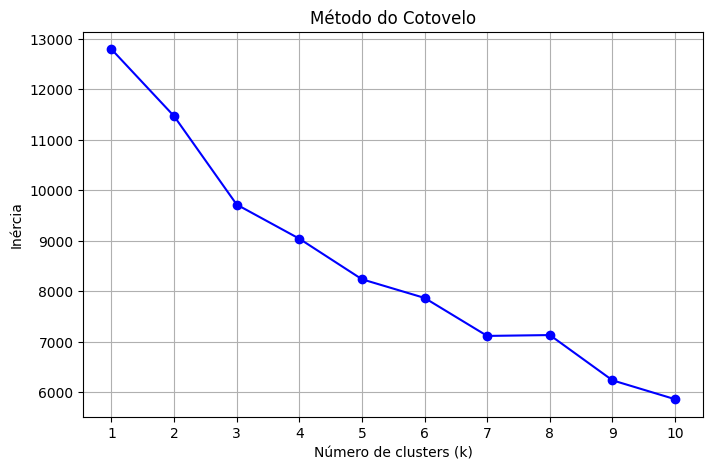

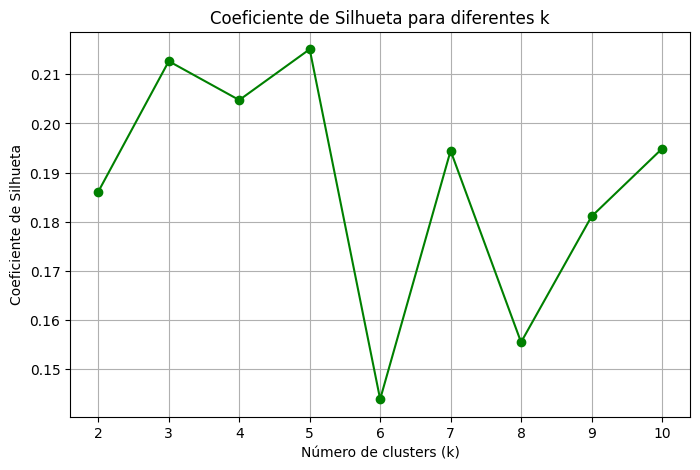

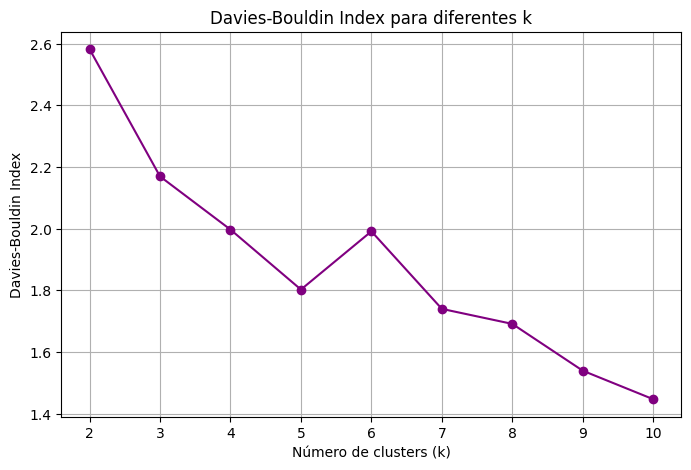

Melhor quantidade de clusters: 5 | Silhueta: 0.2151291277409205
Melhor quantidade de clusters: 10 | Davies Bouldin Index: 1.4468376125362141
Melhor quantidade de clusters pelo OptimalK: 10


In [222]:
kmeans_clusters_amount_analysis(refined_df, max_clusters=10)

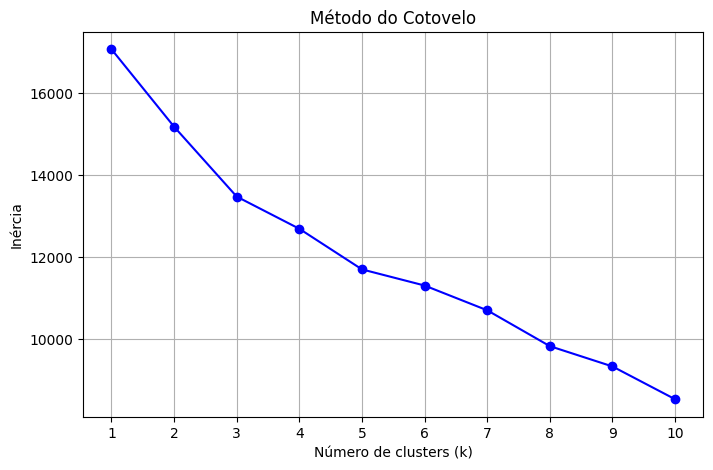

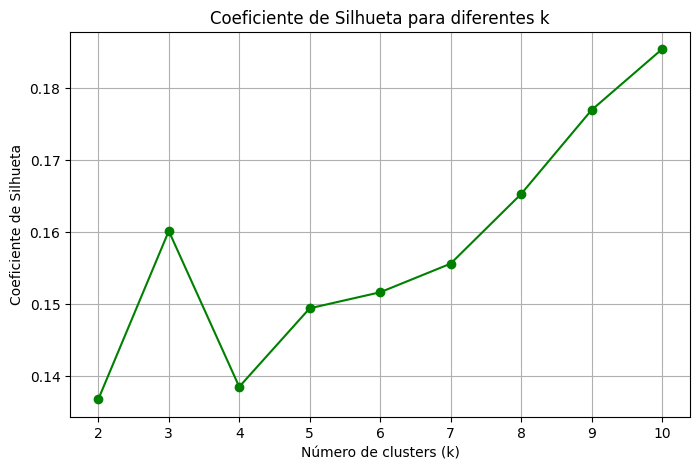

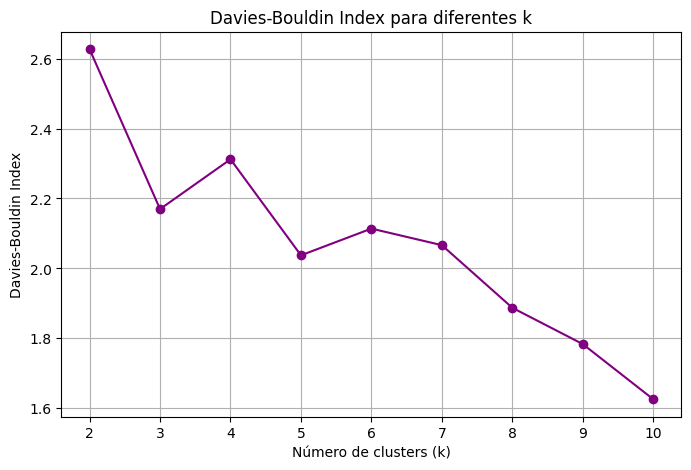

Melhor quantidade de clusters: 10 | Silhueta: 0.18534198095218662
Melhor quantidade de clusters: 10 | Davies Bouldin Index: 1.626059832164967
Melhor quantidade de clusters pelo OptimalK: 1


In [223]:
kmeans_clusters_amount_analysis(not_refined_df, max_clusters=10)

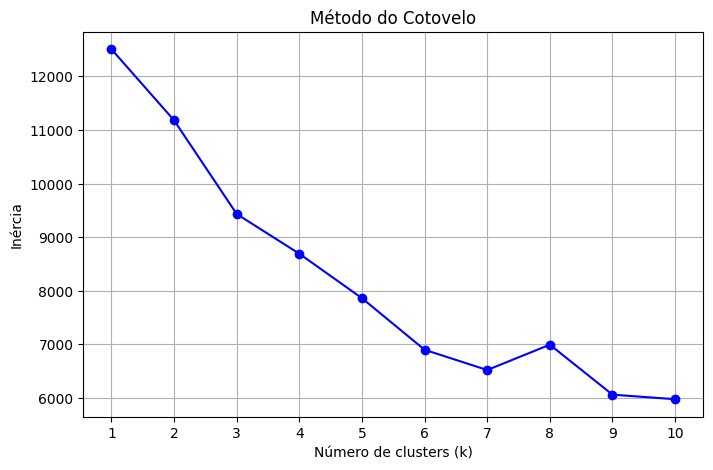

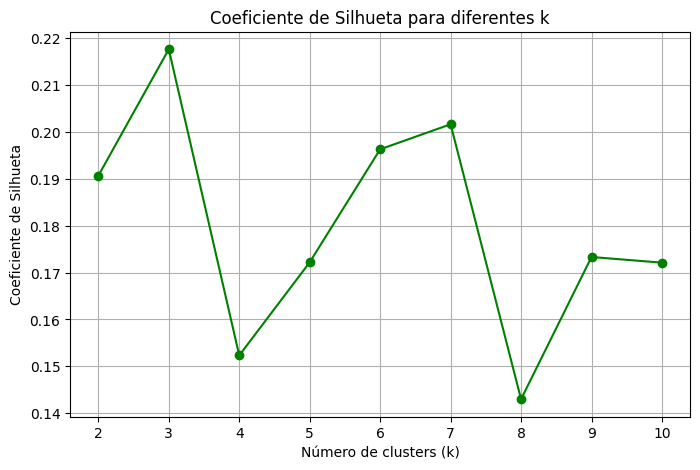

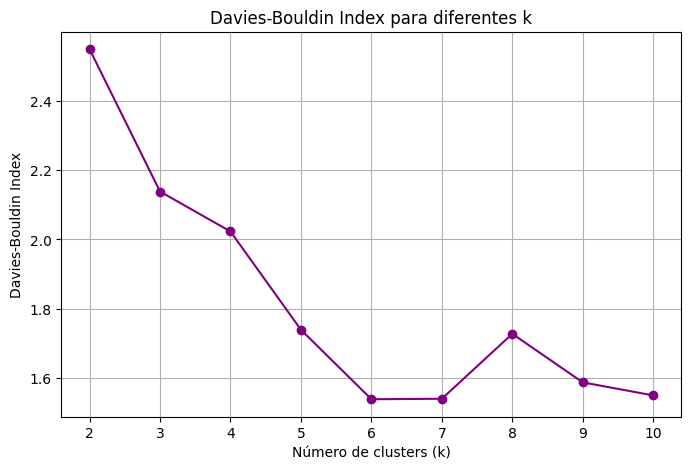

Melhor quantidade de clusters: 3 | Silhueta: 0.21764193986238584
Melhor quantidade de clusters: 6 | Davies Bouldin Index: 1.5393767831116383
Melhor quantidade de clusters pelo OptimalK: 9


In [224]:
kmeans_clusters_amount_analysis(pca_df, max_clusters=10)

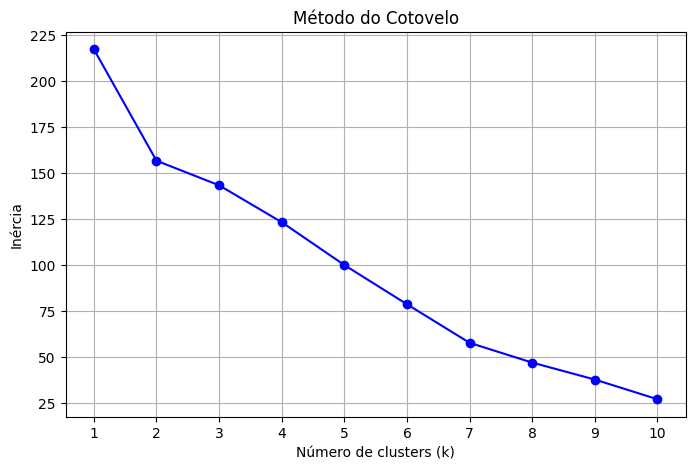

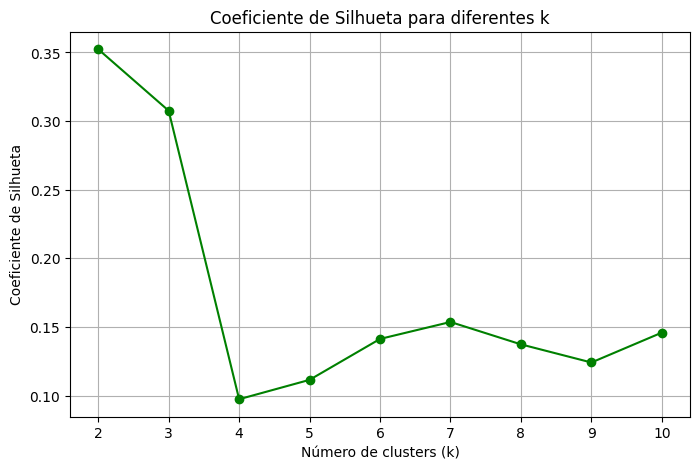

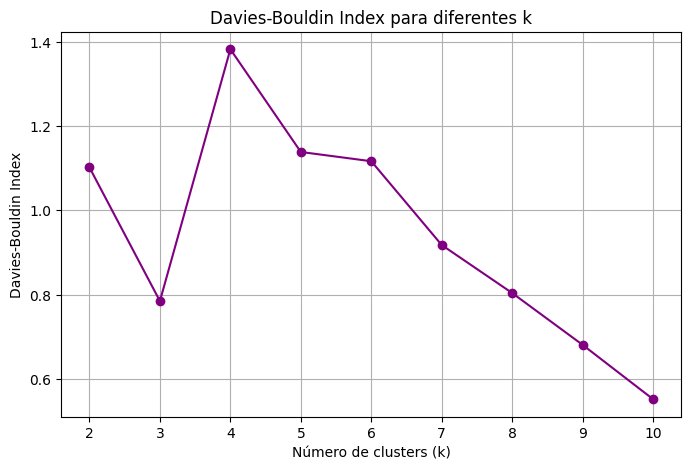

Melhor quantidade de clusters: 2 | Silhueta: 0.35232202532197254
Melhor quantidade de clusters: 10 | Davies Bouldin Index: 0.551337967410608
Melhor quantidade de clusters pelo OptimalK: 10


In [225]:
kmeans_clusters_amount_analysis(smokers_df, max_clusters=10)

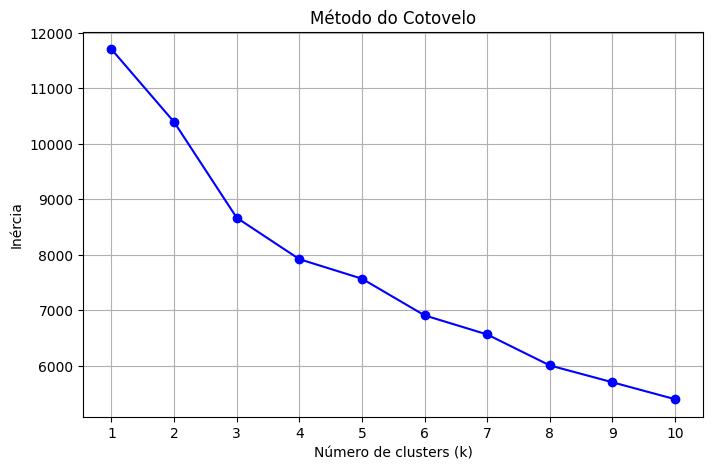

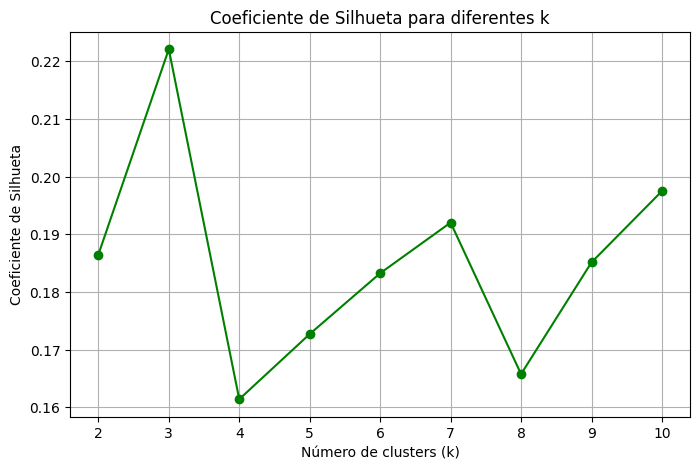

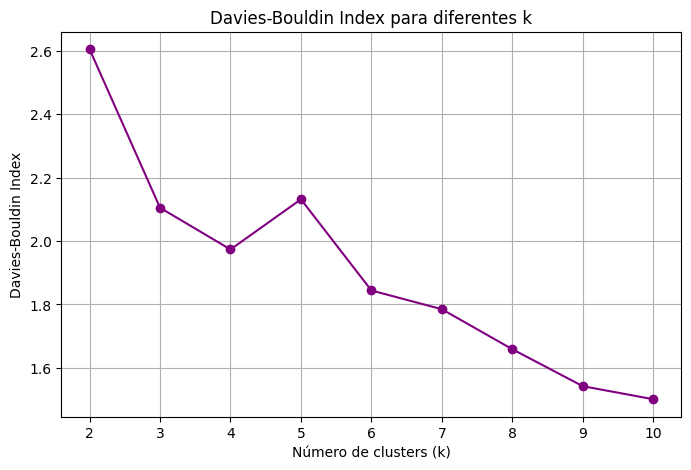

Melhor quantidade de clusters: 3 | Silhueta: 0.22208411614200899
Melhor quantidade de clusters: 10 | Davies Bouldin Index: 1.5013157759498685
Melhor quantidade de clusters pelo OptimalK: 10


In [226]:
kmeans_clusters_amount_analysis(not_smokers_df, max_clusters=10)

/home/gfrasson/projects/ufjf/09periodo/mineracao-dados/trabalho/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



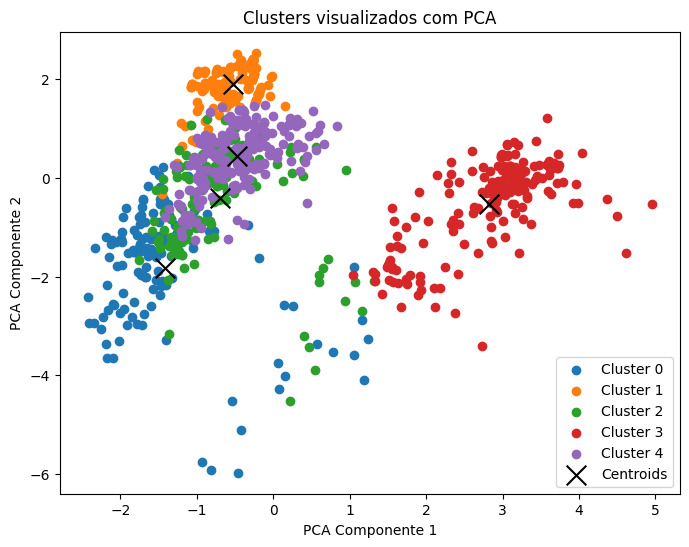

In [227]:
kmeans_analysis(refined_df, 5)

/home/gfrasson/projects/ufjf/09periodo/mineracao-dados/trabalho/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



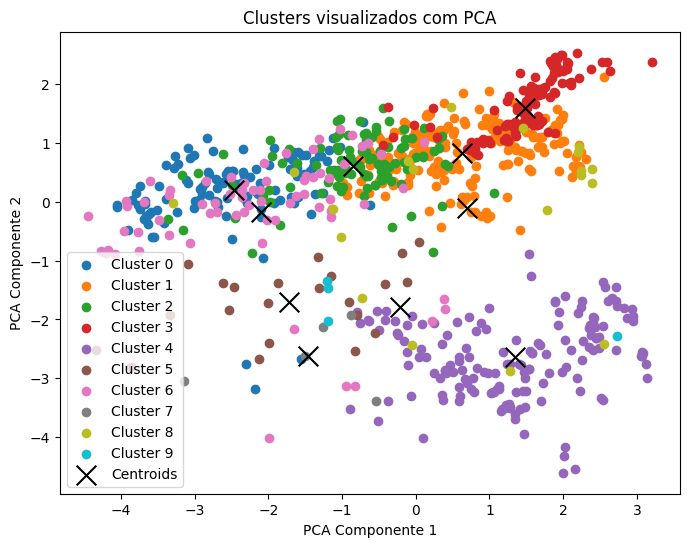

In [228]:
kmeans_analysis(not_refined_df, 10)

/home/gfrasson/projects/ufjf/09periodo/mineracao-dados/trabalho/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



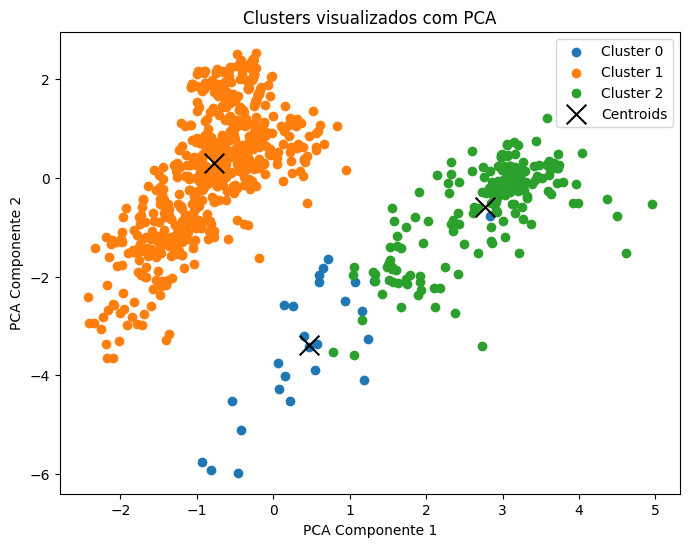

In [229]:
kmeans_analysis(pca_df, 3)

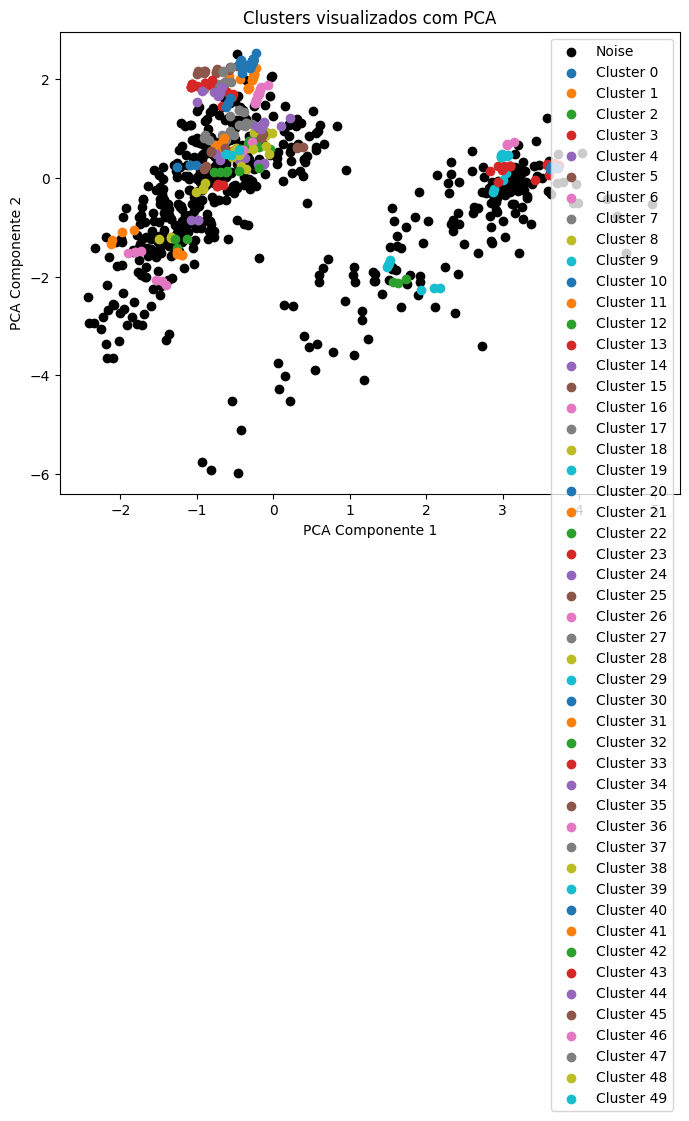

In [238]:
dbscan_analysis(refined_df, eps=0.5, min_samples=3)